In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models


In [ ]:
# === CONFIGURATION ===
DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'
IMAGES_DIR_1 = DATA_DIR + '/HAM10000_images_part_1/'
IMAGES_DIR_2 = DATA_DIR + '/HAM10000_images_part_2/'
METADATA_FILE = DATA_DIR + '/HAM10000_metadata.csv'
IMG_SIZE = 224  # Adjusted as per provided data
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE  # Optimizes performance

In [ ]:
import os
# Set environment variables before any other imports
os.environ["TRANSFORMERS_NO_TF"] = "1"  # This is more explicit than USE_TF=0
os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
# Use ViTImageProcessor instead of ViTFeatureExtractor
from transformers import ViTModel, ViTImageProcessor
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# === CONFIGURATION ===
DATA_DIR = './data/skin-cancer-mnist-ham10000'  # Update this path
IMAGES_DIR_1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMAGES_DIR_2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')
METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
OUTPUT_DIR = './output'  # Directory for outputs (models, plots)

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 300
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0005
VIT_IMG_SIZE = 224  # ViT input size

# === LOAD METADATA ===
df = pd.read_csv(METADATA_FILE, usecols=["image_id", "dx"])
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# === SPLIT DATASET ===
train_df = df.sample(frac=0.8, random_state=42)  # 80% train
remaining_df = df.drop(train_df.index)
val_df = remaining_df.sample(frac=0.5, random_state=42)  # 10% validation
test_df = remaining_df.drop(val_df.index)  # 10% test

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# === AUGMENTATION PIPELINE ===
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# === LOAD ViT IMAGE PROCESSOR ===
try:
    vit_image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    print("ViT image processor loaded successfully")
except Exception as e:
    print(f"Error loading ViT image processor: {e}")
    print("Trying with alternative approach...")
    # Fallback to basic transforms if the image processor fails
    vit_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((VIT_IMG_SIZE, VIT_IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Function to process images for ViT without the feature extractor
def process_image_for_vit(image):
    """Process an image for ViT using basic transforms if image processor fails."""
    try:
        # First try using the image processor
        if 'vit_image_processor' in globals():
            features = vit_image_processor(images=image, return_tensors="pt")
            return features["pixel_values"][0]
    except:
        # Fallback to basic transforms
        if isinstance(image, np.ndarray):
            # Convert numpy array to tensor
            tensor_image = vit_transform(image)
            return tensor_image

    # If all else fails, resize and normalize manually
    resized = cv2.resize(image, (VIT_IMG_SIZE, VIT_IMG_SIZE))
    # Convert to float and normalize to [0,1]
    normalized = resized.astype(np.float32) / 255.0
    # Channel-first for PyTorch
    transposed = normalized.transpose(2, 0, 1)
    # Convert to tensor
    tensor_image = torch.from_numpy(transposed)
    # ImageNet normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    normalized_tensor = normalize(tensor_image)
    return normalized_tensor

# === CUSTOM DATASET CLASS ===
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_training=True):
        self.dataframe = dataframe
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]["image_id"]
        label = self.dataframe.iloc[idx]["label"]

        # Add .jpg extension if needed
        if not image_id.endswith('.jpg'):
            image_id = f"{image_id}.jpg"

        # Check directories for the image
        image_path = None
        for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
            potential_path = os.path.join(directory, image_id)
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        # Handle missing images
        if image_path is None:
            print(f"Warning: Image not found: {image_id}, using placeholder")
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        else:
            # Load and convert image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Could not read image: {image_path}, using placeholder")
                image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms for CNN
        if self.transform:
            transformed = self.transform(image=image)
            cnn_image = transformed["image"]
        else:
            cnn_image = torch.from_numpy(image.transpose(2, 0, 1).astype(np.float32) / 255.0)

        # Process for ViT using our custom function
        vit_image = process_image_for_vit(image)

        return {"cnn_image": cnn_image, "vit_image": vit_image, "label": torch.tensor(label, dtype=torch.long)}

# === CREATE DATASETS AND DATALOADERS ===
train_dataset = SkinCancerDataset(train_df, transform=train_transform, is_training=True)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform, is_training=False)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Dataloaders created successfully")

# === VERIFY DATA SHAPE ===
# It's good to check the shape of the data to ensure it's what we expect
sample_batch = next(iter(train_loader))
print(f"CNN image shape: {sample_batch['cnn_image'].shape}")
print(f"ViT image shape: {sample_batch['vit_image'].shape}")
print(f"Label shape: {sample_batch['label'].shape}")

# === HYBRID MODEL ARCHITECTURE ===
class HybridModel(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(HybridModel, self).__init__()

        # CNN Part (EfficientNet-B3)
        self.cnn_model = models.efficientnet_b3(pretrained=True)
        # Freeze early layers
        for name, param in list(self.cnn_model.named_parameters())[:-30]:
            param.requires_grad = False

        # Replace classifier
        num_ftrs_cnn = self.cnn_model.classifier[1].in_features
        self.cnn_model.classifier = nn.Identity()

        # ViT Part
        try:
            self.vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
            # Freeze ViT parameters
            for param in self.vit_model.parameters():
                param.requires_grad = False

            vit_output_dim = self.vit_model.config.hidden_size  # 768 for base
        except Exception as e:
            print(f"Error loading ViT model: {e}")
            print("Using a simplified model architecture...")
            self.vit_model = None
            vit_output_dim = 0  # No ViT contribution

        # Adjusted feature fusion network based on available models
        if self.vit_model is not None:
            # Feature fusion network with both CNN and ViT
            self.fusion = nn.Sequential(
                nn.Linear(num_ftrs_cnn + vit_output_dim, 768),
                nn.ReLU(),
                nn.BatchNorm1d(768),
                nn.Dropout(0.5),
                nn.Linear(768, 384),
                nn.ReLU(),
                nn.BatchNorm1d(384),
                nn.Dropout(0.4),
                nn.Linear(384, 192),
                nn.ReLU(),
                nn.BatchNorm1d(192),
                nn.Dropout(0.3),
                nn.Linear(192, num_classes)
            )
        else:
            # Use only CNN features if ViT is not available
            self.fusion = nn.Sequential(
                nn.Linear(num_ftrs_cnn, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.4),
                nn.Linear(256, num_classes)
            )

    def forward(self, cnn_input, vit_input=None):
        # CNN forward pass
        cnn_features = self.cnn_model(cnn_input)

        # ViT forward pass - if available
        if self.vit_model is not None and vit_input is not None:
            vit_outputs = self.vit_model(pixel_values=vit_input).last_hidden_state[:, 0, :]
            # Concatenate features
            combined_features = torch.cat((cnn_features, vit_outputs), dim=1)
        else:
            # Use only CNN features
            combined_features = cnn_features

        # Pass through fusion network
        logits = self.fusion(combined_features)

        return logits

# === TRAINING FUNCTION ===
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_acc = 0.0
    best_model_weights = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for batch in progress_bar:
            cnn_inputs = batch["cnn_image"].to(device)
            vit_inputs = batch["vit_image"].to(device)
            labels = batch["label"].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(cnn_inputs, vit_inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * cnn_inputs.size(0)
            running_corrects += torch.sum(preds == labels)

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")

        for batch in progress_bar:
            cnn_inputs = batch["cnn_image"].to(device)
            vit_inputs = batch["vit_image"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            with torch.no_grad():
                outputs = model(cnn_inputs, vit_inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * cnn_inputs.size(0)
            running_corrects += torch.sum(preds == labels)

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects.double() / len(val_dataset)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())

        # Learning rate scheduler step
        scheduler.step(epoch_loss)

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = model.state_dict().copy()
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_weights,
                'optimizer_state_dict': optimizer.state_dict(),
                'acc': best_acc,
            }, os.path.join(OUTPUT_DIR, 'best_hybrid_model.pth'))
            print(f"New best model saved with accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model, history

# === CREATE MODEL AND OPTIMIZER ===
model = HybridModel()
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# === TRAIN THE MODEL ===
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('EfficientNetB3+ViT Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('EfficientNetB3+ViT Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    history_plot_path = os.path.join(OUTPUT_DIR, 'efficientnet_vit_history.png')
    plt.savefig(history_plot_path)
    print(f"Training history saved to {history_plot_path}")
    plt.show()

except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

# === EVALUATE MODEL ===
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            cnn_inputs = batch["cnn_image"].to(device)
            vit_inputs = batch["vit_image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(cnn_inputs, vit_inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * cnn_inputs.size(0)
            running_corrects += torch.sum(preds == labels)

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

    return test_loss, test_acc

try:
    print("Evaluating model on test dataset...")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
except Exception as e:
    print(f"Evaluation error: {e}")

# === VISUALIZATION OF MODEL PREDICTIONS ===
def visualize_predictions(model, test_loader, num_images=5):
    """Visualize model predictions on a few images."""
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(15, 3*num_images))

    with torch.no_grad():
        for batch in test_loader:
            cnn_images = batch["cnn_image"].to(device)
            vit_images = batch["vit_image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(cnn_images, vit_images)
            _, preds = torch.max(outputs, 1)

            for i in range(cnn_images.size(0)):
                images_so_far += 1
                if images_so_far <= num_images:
                    ax = plt.subplot(num_images, 1, images_so_far)

                    # Convert tensor to numpy for plotting
                    img = cnn_images[i].cpu().numpy().transpose((1, 2, 0))
                    # Denormalize
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)

                    plt.imshow(img)

                    true_label = CLASS_NAMES[labels[i].item()]
                    pred_label = CLASS_NAMES[preds[i].item()]

                    # Add prediction confidence
                    confidence = torch.nn.functional.softmax(outputs[i], dim=0)[preds[i]] * 100

                    color = 'green' if true_label == pred_label else 'red'
                    plt.title(f"True: {true_label}, Pred: {pred_label} ({confidence:.1f}%)", color=color)
                    plt.axis('off')

                if images_so_far == num_images:
                    predictions_plot_path = os.path.join(OUTPUT_DIR, 'efficientnet_vit_predictions.png')
                    plt.tight_layout()
                    plt.savefig(predictions_plot_path)
                    print(f"Predictions visualization saved to {predictions_plot_path}")
                    plt.show()
                    return

try:
    print("Visualizing model predictions...")
    visualize_predictions(model, test_loader)
except Exception as e:
    print(f"Visualization error: {e}")

# === CONFUSION MATRIX ===
def plot_confusion_matrix(model, test_loader):
    """Generate and plot confusion matrix."""
    model.eval()

    # Collect true labels and predictions
    true_labels = []
    predictions = []

    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for batch in tqdm(test_loader):
            cnn_images = batch["cnn_image"].to(device)
            vit_images = batch["vit_image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(cnn_images, vit_images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - EfficientNetB3+ViT')
    plt.tight_layout()
    confusion_matrix_path = os.path.join(OUTPUT_DIR, 'efficientnet_vit_confusion_matrix.png')
    plt.savefig(confusion_matrix_path)
    print(f"Confusion matrix saved to {confusion_matrix_path}")
    plt.show()

    # Print classification report
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(true_labels, predictions, target_names=CLASS_NAMES))

try:
    plot_confusion_matrix(model, test_loader)
except Exception as e:
    print(f"Confusion matrix error: {e}")

# === SAVE FINAL MODEL ===
try:
    final_model_path = os.path.join(OUTPUT_DIR, 'final_hybrid_model.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': CLASS_NAMES,
        'class_to_index': class_to_index,
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")
except Exception as e:
    print(f"Error saving model: {e}")

# === MODEL SUMMARY AND RESULTS ===
print("\n=== MODEL SUMMARY ===")
print(f"CNN Backbone: EfficientNet-B3")
if hasattr(model, 'vit_model') and model.vit_model is not None:
    print(f"ViT Model: google/vit-base-patch16-224")
else:
    print("ViT Model: Not used (fallback to CNN-only)")
print(f"Number of Classes: {len(CLASS_NAMES)}")
print(f"Classes: {', '.join(CLASS_NAMES)}")
print(f"Image Size for CNN: {IMG_SIZE}x{IMG_SIZE}")
print(f"Image Size for ViT: {VIT_IMG_SIZE}x{VIT_IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Training Set Size: {len(train_df)}")
print(f"Validation Set Size: {len(val_df)}")
print(f"Test Set Size: {len(test_df)}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Device: {device}")

RuntimeError: Failed to import transformers.models.vit.image_processing_vit because of the following error (look up to see its traceback):
No module named 'tensorflow.python.data.experimental.ops.iterator_model_ops'

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import cv2
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import albumentations as A

# Paths
DATA_DIR = './data'
IMAGES_DIR_1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMAGES_DIR_2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')
METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')

# Load a small subset of metadata for testing
df = pd.read_csv(METADATA_FILE, usecols=["image_id", "dx"])
test_df = df.sample(n=10, random_state=42)  # Just use 10 images
class_to_index = {cls: idx for idx, cls in enumerate(df["dx"].unique())}
test_df["label"] = test_df["dx"].map(class_to_index)

IMG_SIZE = 224
PLACEHOLDER_IMAGE = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

# Simple transforms
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        print("Dataset initialized")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        print(f"Loading item {idx}")
        image_id = self.df.iloc[idx]["image_id"]
        label = self.df.iloc[idx]["label"]

        # Add .jpg extension if needed
        if not image_id.endswith('.jpg'):
            image_id = f"{image_id}.jpg"

        # Search for image
        image_path = None
        for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
            potential_path = os.path.join(directory, image_id)
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        print(f"Image path: {image_path}")

        # Load image with error handling
        try:
            if image_path is None:
                print(f"Image not found: {image_id}")
                image = PLACEHOLDER_IMAGE.copy()
            else:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Failed to read: {image_path}")
                    image = PLACEHOLDER_IMAGE.copy()
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    print(f"Image loaded successfully: {image.shape}")
        except Exception as e:
            print(f"Error loading image {image_id}: {e}")
            image = PLACEHOLDER_IMAGE.copy()

        # Apply transforms
        if self.transform:
            try:
                transformed = self.transform(image=image)
                image = transformed["image"]
                print(f"Transform applied successfully: {image.shape}")
            except Exception as e:
                print(f"Transform error: {e}")
                # Return a zero tensor as fallback
                image = torch.zeros((3, IMG_SIZE, IMG_SIZE))

        return image, torch.tensor(label, dtype=torch.long)

# Create dataset
test_dataset = TestDataset(test_df, transform)
print("Dataset created")

# Try to get first item directly (no dataloader)
try:
    print("Testing direct item access...")
    img, label = test_dataset[0]
    print(f"Direct access successful: {img.shape}, label: {label}")
except Exception as e:
    print(f"Direct access failed: {e}")

# Try with dataloader (no workers)
try:
    print("Testing dataloader with 0 workers...")
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
    print("Dataloader created")

    for batch_idx, (images, labels) in enumerate(test_loader):
        print(f"Batch {batch_idx}: {images.shape}, {labels.shape}")
        if batch_idx >= 2:  # Only test a few batches
            break

except Exception as e:
    print(f"Dataloader test failed: {e}")

print("Test completed")

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset initialized
Dataset created
Testing direct item access...
Loading item 0
Image path: ./data\HAM10000_images_part_2\ISIC_0033272.jpg
Image loaded successfully: (450, 600, 3)
Transform applied successfully: torch.Size([3, 224, 224])
Direct access successful: torch.Size([3, 224, 224]), label: 3
Testing dataloader with 0 workers...
Dataloader created
Loading item 0
Image path: ./data\HAM10000_images_part_2\ISIC_0033272.jpg
Image loaded successfully: (450, 600, 3)
Transform applied successfully: torch.Size([3, 224, 224])
Loading item 1
Image path: ./data\HAM10000_images_part_2\ISIC_0031923.jpg
Image loaded successfully: (450, 600, 3)
Transform applied successfully: torch.Size([3, 224, 224])
Batch 0: torch.Size([2, 3, 224, 224]), torch.Size([2])
Loading item 2
Image path: ./data\HAM10000_images_part_1\ISIC_0026652.jpg
Image loaded successfully: (450, 600, 3)
Transform applied successfully: torch.Size([3, 224, 224])
Loading item 3
Image path: ./data\HAM10000_images_part_2\ISIC_0030583

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
Memory: 12.88 GB
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 8012 images
Validation set: 1002 images
Test set: 1001 images
Creating datasets...
Testing dataset access...
Successfully loaded first sample with shape: torch.Size([3, 224, 224])
Creating dataloaders...
Dataloaders created successfully
Testing batch loading...
Successfully loaded first batch: torch.Size([16, 3, 224, 224])
Creating model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\User/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 10.6MB/s]


Total parameters: 4,016,515
Trainable parameters: 3,963,105
Starting model training...
Epoch 1/15
----------


Epoch 1/15 [Train]: 100%|██████████| 501/501 [02:13<00:00,  3.74it/s, loss=0.521]


Train Loss: 0.6918 Acc: 0.7556


Epoch 1/15 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s, loss=0.384]


Val Loss: 0.4855 Acc: 0.8413
New best model saved with accuracy: 0.8413
Epoch 2/15
----------


Epoch 2/15 [Train]: 100%|██████████| 501/501 [00:58<00:00,  8.50it/s, loss=0.214]


Train Loss: 0.5045 Acc: 0.8165


Epoch 2/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.39it/s, loss=0.343] 


Val Loss: 0.4116 Acc: 0.8543
New best model saved with accuracy: 0.8543
Epoch 3/15
----------


Epoch 3/15 [Train]: 100%|██████████| 501/501 [01:00<00:00,  8.33it/s, loss=0.517] 


Train Loss: 0.4243 Acc: 0.8469


Epoch 3/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.21it/s, loss=0.369] 


Val Loss: 0.4512 Acc: 0.8543
Epoch 4/15
----------


Epoch 4/15 [Train]: 100%|██████████| 501/501 [00:58<00:00,  8.51it/s, loss=0.597] 


Train Loss: 0.3705 Acc: 0.8662


Epoch 4/15 [Val]: 100%|██████████| 63/63 [00:06<00:00,  9.98it/s, loss=0.464] 


Val Loss: 0.3997 Acc: 0.8663
New best model saved with accuracy: 0.8663
Epoch 5/15
----------


Epoch 5/15 [Train]: 100%|██████████| 501/501 [00:58<00:00,  8.53it/s, loss=0.331] 


Train Loss: 0.3318 Acc: 0.8773


Epoch 5/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.34it/s, loss=0.159] 


Val Loss: 0.4102 Acc: 0.8633
Epoch 6/15
----------


Epoch 6/15 [Train]: 100%|██████████| 501/501 [01:00<00:00,  8.33it/s, loss=0.0901]


Train Loss: 0.2917 Acc: 0.8912


Epoch 6/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.47it/s, loss=0.248] 


Val Loss: 0.3703 Acc: 0.8743
New best model saved with accuracy: 0.8743
Epoch 7/15
----------


Epoch 7/15 [Train]: 100%|██████████| 501/501 [00:59<00:00,  8.45it/s, loss=0.0615]


Train Loss: 0.2682 Acc: 0.8987


Epoch 7/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.50it/s, loss=0.379] 


Val Loss: 0.4331 Acc: 0.8613
Epoch 8/15
----------


Epoch 8/15 [Train]: 100%|██████████| 501/501 [00:59<00:00,  8.40it/s, loss=0.302] 


Train Loss: 0.2479 Acc: 0.9083


Epoch 8/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.26it/s, loss=0.277] 


Val Loss: 0.3868 Acc: 0.8912
New best model saved with accuracy: 0.8912
Epoch 9/15
----------


Epoch 9/15 [Train]: 100%|██████████| 501/501 [00:59<00:00,  8.36it/s, loss=0.782] 


Train Loss: 0.2178 Acc: 0.9239


Epoch 9/15 [Val]: 100%|██████████| 63/63 [00:05<00:00, 11.46it/s, loss=0.266] 


Val Loss: 0.4678 Acc: 0.8713
Epoch 10/15
----------


Epoch 10/15 [Train]: 100%|██████████| 501/501 [00:58<00:00,  8.55it/s, loss=0.0785]


Train Loss: 0.2013 Acc: 0.9267


Epoch 10/15 [Val]: 100%|██████████| 63/63 [00:05<00:00, 10.99it/s, loss=0.089] 


Val Loss: 0.3838 Acc: 0.8812
Epoch 11/15
----------


Epoch 11/15 [Train]: 100%|██████████| 501/501 [00:57<00:00,  8.64it/s, loss=0.124]  


Train Loss: 0.1545 Acc: 0.9453


Epoch 11/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.31it/s, loss=0.0762] 


Val Loss: 0.3506 Acc: 0.8912
Epoch 12/15
----------


Epoch 12/15 [Train]: 100%|██████████| 501/501 [00:57<00:00,  8.65it/s, loss=0.117]  


Train Loss: 0.1206 Acc: 0.9582


Epoch 12/15 [Val]: 100%|██████████| 63/63 [00:05<00:00, 11.51it/s, loss=0.0493] 


Val Loss: 0.3537 Acc: 0.9092
New best model saved with accuracy: 0.9092
Epoch 13/15
----------


Epoch 13/15 [Train]: 100%|██████████| 501/501 [00:59<00:00,  8.44it/s, loss=0.0665] 


Train Loss: 0.1116 Acc: 0.9603


Epoch 13/15 [Val]: 100%|██████████| 63/63 [00:06<00:00, 10.11it/s, loss=0.157]  


Val Loss: 0.3742 Acc: 0.8922
Epoch 14/15
----------


Epoch 14/15 [Train]: 100%|██████████| 501/501 [00:59<00:00,  8.48it/s, loss=0.273]  


Train Loss: 0.0961 Acc: 0.9653


Epoch 14/15 [Val]: 100%|██████████| 63/63 [00:05<00:00, 10.99it/s, loss=0.0241]


Val Loss: 0.3762 Acc: 0.8942
Epoch 15/15
----------


Epoch 15/15 [Train]: 100%|██████████| 501/501 [00:58<00:00,  8.55it/s, loss=0.241]  


Train Loss: 0.0891 Acc: 0.9683


Epoch 15/15 [Val]: 100%|██████████| 63/63 [00:05<00:00, 10.54it/s, loss=0.0324] 


Val Loss: 0.4319 Acc: 0.8852
Training history saved to ./output\efficientnet_history.png
Evaluating model on test dataset...
Starting evaluation...


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.54it/s]


Test Loss: 0.4207
Test Accuracy: 0.8851 (88.51%)


100%|██████████| 63/63 [00:05<00:00, 11.06it/s]


Confusion matrix saved to ./output\efficientnet_confusion_matrix.png

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         bkl       0.86      0.72      0.79       119
          nv       0.94      0.94      0.94       691
          df       0.86      0.55      0.67        11
         mel       0.59      0.83      0.69        86
        vasc       1.00      0.80      0.89        15
         bcc       0.89      0.82      0.85        49
       akiec       0.77      0.67      0.71        30

    accuracy                           0.89      1001
   macro avg       0.84      0.76      0.79      1001
weighted avg       0.89      0.89      0.89      1001

Visualizing model predictions...
Predictions visualization saved to ./output\efficientnet_predictions.png
Final model saved to ./output\final_model.pth

=== MODEL SUMMARY ===
Model: EfficientNet-B0
Number of Classes: 7
Classes: bkl, nv, df, mel, vasc, bcc, akiec
Image Size: 224x224
Batch Size: 16
Train

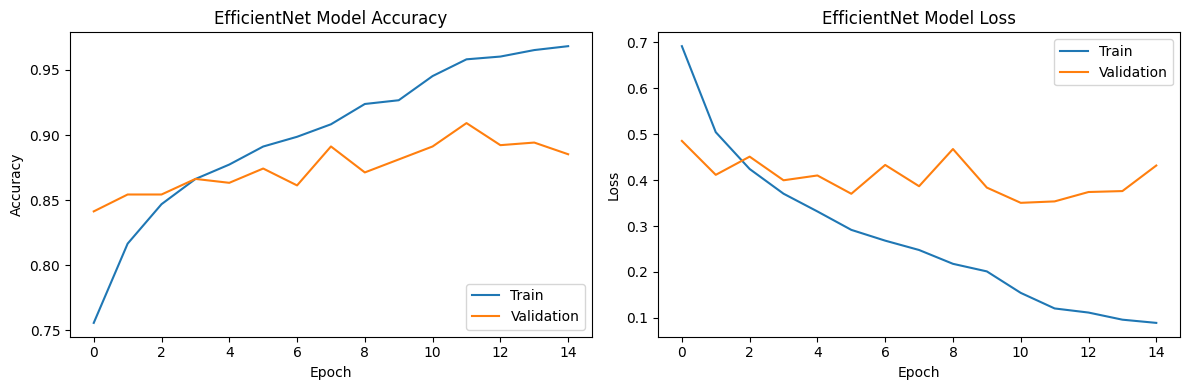

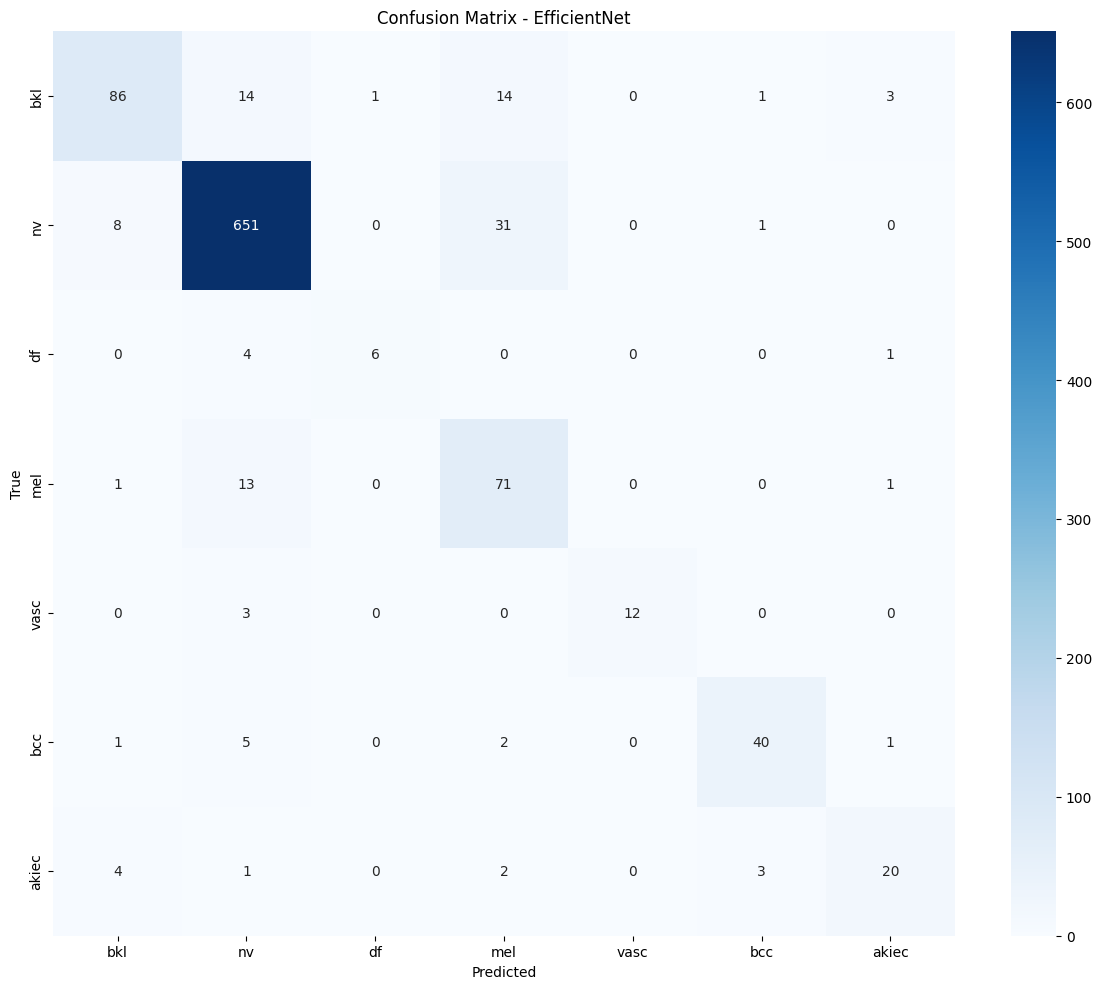

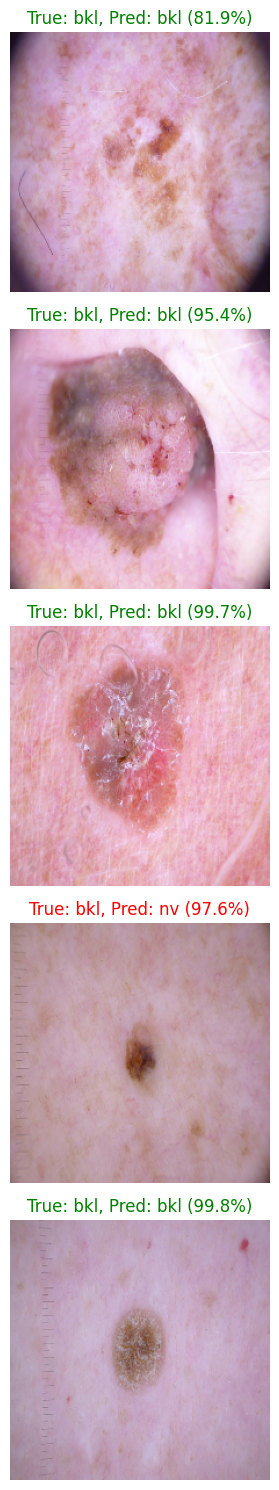

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# === CONFIGURATION ===
DATA_DIR = './data'
IMAGES_DIR_1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMAGES_DIR_2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')
METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
OUTPUT_DIR = './output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224  # Standard size for most models
BATCH_SIZE = 16
EPOCHS = 15  # Reduced from 100 for faster training
LEARNING_RATE = 0.0003

# === LOAD METADATA ===
df = pd.read_csv(METADATA_FILE, usecols=["image_id", "dx"])
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# === SPLIT DATASET ===
train_df = df.sample(frac=0.8, random_state=42)
remaining_df = df.drop(train_df.index)
val_df = remaining_df.sample(frac=0.5, random_state=42)
test_df = remaining_df.drop(val_df.index)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# === AUGMENTATION PIPELINE ===
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Create a placeholder image
PLACEHOLDER_IMAGE = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

# === CUSTOM DATASET CLASS ===
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # Cache for found image paths
        self.image_path_cache = {}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]["image_id"]
        label = self.dataframe.iloc[idx]["label"]

        # Add .jpg extension if needed
        if not image_id.endswith('.jpg'):
            image_id = f"{image_id}.jpg"

        # Check cache first
        if image_id in self.image_path_cache:
            image_path = self.image_path_cache[image_id]
        else:
            # Check directories for the image
            image_path = None
            for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                potential_path = os.path.join(directory, image_id)
                if os.path.exists(potential_path):
                    image_path = potential_path
                    # Cache the found path
                    self.image_path_cache[image_id] = image_path
                    break

        # Handle missing images
        try:
            if image_path is None:
                image = PLACEHOLDER_IMAGE.copy()
            else:
                image = cv2.imread(image_path)
                if image is None:
                    image = PLACEHOLDER_IMAGE.copy()
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception:
            image = PLACEHOLDER_IMAGE.copy()

        # Apply transforms
        if self.transform:
            try:
                transformed = self.transform(image=image)
                image = transformed["image"]
            except Exception:
                # Fallback if transform fails
                image = torch.zeros((3, IMG_SIZE, IMG_SIZE))

        return image, torch.tensor(label, dtype=torch.long)

# === CREATE DATASETS AND DATALOADERS ===
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Test direct access to dataset
print("Testing dataset access...")
try:
    sample_img, sample_label = train_dataset[0]
    print(f"Successfully loaded first sample with shape: {sample_img.shape}")
except Exception as e:
    print(f"Error accessing dataset: {e}")

# Create dataloaders with 0 workers to avoid potential deadlocks
print("Creating dataloaders...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created successfully")

# Test batch loading
print("Testing batch loading...")
sample_batch, sample_labels = next(iter(train_loader))
print(f"Successfully loaded first batch: {sample_batch.shape}")

# === MODEL ARCHITECTURE ===
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetModel, self).__init__()

        # Use EfficientNet-B0 (smaller and faster than B3)
        self.backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')

        # Freeze early layers
        for name, param in list(self.backbone.named_parameters())[:60]:  # Freeze first 60 params
            param.requires_grad = False

        # Replace the classifier
        num_ftrs = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# === CREATE MODEL AND OPTIMIZER ===
print("Creating model...")
model = EfficientNetModel()
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# === TRAINING FUNCTION ===
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_acc = 0.0
    best_model_weights = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 5
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

            # Free memory
            del inputs, labels, outputs, preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")

        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar
                progress_bar.set_postfix(loss=loss.item())

                # Free memory
                del inputs, labels, outputs, preds
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects.double() / len(val_dataset)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())

        # Learning rate scheduler step
        scheduler.step(epoch_loss)

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = model.state_dict().copy()
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_weights,
                'optimizer_state_dict': optimizer.state_dict(),
                'acc': best_acc,
            }, os.path.join(OUTPUT_DIR, 'best_model.pth'))
            print(f"New best model saved with accuracy: {best_acc:.4f}")

        # Early stopping check
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model, history

# === TRAIN THE MODEL ===
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('EfficientNet Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('EfficientNet Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    history_plot_path = os.path.join(OUTPUT_DIR, 'efficientnet_history.png')
    plt.savefig(history_plot_path)
    print(f"Training history saved to {history_plot_path}")

except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

# === EVALUATE MODEL ===
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    print("Starting evaluation...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Free memory
            del inputs, labels, outputs, preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

    return test_loss, test_acc

try:
    print("Evaluating model on test dataset...")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
except Exception as e:
    print(f"Evaluation error: {e}")
    import traceback
    traceback.print_exc()

# === CONFUSION MATRIX ===
def plot_confusion_matrix(model, test_loader):
    """Generate and plot confusion matrix."""
    model.eval()

    # Collect true labels and predictions
    true_labels = []
    predictions = []

    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

            # Free memory
            del inputs, labels, outputs, preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - EfficientNet')
    plt.tight_layout()
    confusion_matrix_path = os.path.join(OUTPUT_DIR, 'efficientnet_confusion_matrix.png')
    plt.savefig(confusion_matrix_path)
    print(f"Confusion matrix saved to {confusion_matrix_path}")

    # Print classification report
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(true_labels, predictions, target_names=CLASS_NAMES))

try:
    plot_confusion_matrix(model, test_loader)
except Exception as e:
    print(f"Confusion matrix error: {e}")
    import traceback
    traceback.print_exc()

# === VISUALIZE PREDICTIONS ===
def visualize_predictions(model, test_loader, num_images=5):
    """Visualize model predictions on a few images."""
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(15, 3*num_images))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_so_far += 1
                if images_so_far <= num_images:
                    ax = plt.subplot(num_images, 1, images_so_far)

                    # Convert tensor to numpy for plotting
                    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                    # Denormalize
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    img = np.clip(img, 0, 1)

                    plt.imshow(img)

                    true_label = CLASS_NAMES[labels[i].item()]
                    pred_label = CLASS_NAMES[preds[i].item()]

                    # Add prediction confidence
                    confidence = torch.nn.functional.softmax(outputs[i], dim=0)[preds[i]] * 100

                    color = 'green' if true_label == pred_label else 'red'
                    plt.title(f"True: {true_label}, Pred: {pred_label} ({confidence:.1f}%)", color=color)
                    plt.axis('off')

                if images_so_far == num_images:
                    predictions_plot_path = os.path.join(OUTPUT_DIR, 'efficientnet_predictions.png')
                    plt.tight_layout()
                    plt.savefig(predictions_plot_path)
                    print(f"Predictions visualization saved to {predictions_plot_path}")
                    return

try:
    print("Visualizing model predictions...")
    visualize_predictions(model, test_loader)
except Exception as e:
    print(f"Visualization error: {e}")
    import traceback
    traceback.print_exc()

# === SAVE FINAL MODEL ===
try:
    final_model_path = os.path.join(OUTPUT_DIR, 'final_model.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': CLASS_NAMES,
        'class_to_index': class_to_index,
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")
except Exception as e:
    print(f"Error saving model: {e}")

print("\n=== MODEL SUMMARY ===")
print(f"Model: EfficientNet-B0")
print(f"Number of Classes: {len(CLASS_NAMES)}")
print(f"Classes: {', '.join(CLASS_NAMES)}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Set Size: {len(train_df)}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("\nTraining complete!")

# Instructions for loading the hybrid model after this works
print("\n=== NEXT STEPS ===")
print("Once this simplified model runs successfully, you can implement the hybrid model.")
print("A simpler hybrid model implementation would use EfficientNet-B0 instead of B3")
print("and include fewer layers in the fusion network.")

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
from torchvision.models import efficientnet_b3, ViT_B_16_Weights, vision_transformer
import timm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# === CONFIGURATION ===
DATA_DIR = './data'
IMAGES_DIR_1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMAGES_DIR_2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')
METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
OUTPUT_DIR = './output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224  # Standard size for most models
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0002  # Slightly lower learning rate for the hybrid model
WEIGHT_DECAY = 1e-5     # Add weight decay for regularization

# === LOAD METADATA ===
df = pd.read_csv(METADATA_FILE, usecols=["image_id", "dx"])
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# === SPLIT DATASET ===
train_df = df.sample(frac=0.8, random_state=42)
remaining_df = df.drop(train_df.index)
val_df = remaining_df.sample(frac=0.5, random_state=42)
test_df = remaining_df.drop(val_df.index)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# === AUGMENTATION PIPELINE ===
# Enhanced augmentation pipeline for better generalization
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.5),
    ], p=0.2),
    A.OneOf([
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
        A.GridDistortion(p=0.5),
    ], p=0.2),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Create a placeholder image
PLACEHOLDER_IMAGE = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

# === CUSTOM DATASET CLASS ===
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # Cache for found image paths
        self.image_path_cache = {}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx]["image_id"]
        label = self.dataframe.iloc[idx]["label"]

        # Add .jpg extension if needed
        if not image_id.endswith('.jpg'):
            image_id = f"{image_id}.jpg"

        # Check cache first
        if image_id in self.image_path_cache:
            image_path = self.image_path_cache[image_id]
        else:
            # Check directories for the image
            image_path = None
            for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                potential_path = os.path.join(directory, image_id)
                if os.path.exists(potential_path):
                    image_path = potential_path
                    # Cache the found path
                    self.image_path_cache[image_id] = image_path
                    break

        # Handle missing images
        try:
            if image_path is None:
                image = PLACEHOLDER_IMAGE.copy()
            else:
                image = cv2.imread(image_path)
                if image is None:
                    image = PLACEHOLDER_IMAGE.copy()
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception:
            image = PLACEHOLDER_IMAGE.copy()

        # Apply transforms
        if self.transform:
            try:
                transformed = self.transform(image=image)
                image = transformed["image"]
            except Exception:
                # Fallback if transform fails
                image = torch.zeros((3, IMG_SIZE, IMG_SIZE))

        return image, torch.tensor(label, dtype=torch.long)

# === CREATE DATASETS AND DATALOADERS ===
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Test direct access to dataset
print("Testing dataset access...")
try:
    sample_img, sample_label = train_dataset[0]
    print(f"Successfully loaded first sample with shape: {sample_img.shape}")
except Exception as e:
    print(f"Error accessing dataset: {e}")

# Create dataloaders with workers based on CPU availability
num_workers = min(4, os.cpu_count() or 1)
print(f"Using {num_workers} workers for dataloaders")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
print("Dataloaders created successfully")

# Test batch loading
print("Testing batch loading...")
sample_batch, sample_labels = next(iter(train_loader))
print(f"Successfully loaded first batch: {sample_batch.shape}")

# === HYBRID MODEL ARCHITECTURE ===
class HybridEfficientNetViT(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(HybridEfficientNetViT, self).__init__()

        # EfficientNet-B3 as first backbone
        self.efficientnet = efficientnet_b3(weights='IMAGENET1K_V1')
        # Remove the final classifier
        self.efficientnet_features = nn.Sequential(*list(self.efficientnet.children())[:-1])
        efficientnet_out_features = 1536  # EfficientNet-B3 feature dimension

        # Vision Transformer as second backbone
        # Using ViT from timm for more flexibility
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        vit_out_features = 768  # ViT base feature dimension

        # Freeze early layers of both models
        # For EfficientNet - freeze most of the backbone
        for name, param in list(self.efficientnet_features.named_parameters())[:250]:
            param.requires_grad = False

        # For ViT - freeze early transformer blocks
        for name, param in list(self.vit.named_parameters())[:150]:
            param.requires_grad = False

        # Feature fusion network
        self.fusion = nn.Sequential(
            nn.Linear(efficientnet_out_features + vit_out_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

        # Attention mechanism for feature weighting
        self.attention = nn.Sequential(
            nn.Linear(efficientnet_out_features + vit_out_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),  # 2 channels for EfficientNet and ViT
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # EfficientNet forward pass
        eff_features = self.efficientnet_features(x)
        eff_features = torch.flatten(eff_features, 1)

        # Vision Transformer forward pass
        vit_features = self.vit(x)

        # Concatenate features
        combined_features = torch.cat((eff_features, vit_features), dim=1)

        # Apply attention weights
        attention_weights = self.attention(combined_features)
        weighted_eff_features = eff_features * attention_weights[:, 0].unsqueeze(1)
        weighted_vit_features = vit_features * attention_weights[:, 1].unsqueeze(1)

        # Combine weighted features
        weighted_features = torch.cat((weighted_eff_features, weighted_vit_features), dim=1)

        # Final classification
        return self.fusion(weighted_features)

# === CREATE MODEL AND OPTIMIZER ===
print("Creating hybrid model...")
model = HybridEfficientNetViT()
model = model.to(device)

# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr=1e-6):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(min_lr, 0.5 * (1.0 + np.cos(np.pi * progress)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Calculate total training steps
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% of total steps for warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# === MIXUP AUGMENTATION ===
def mixup_data(x, y, alpha=0.2):
    """Applies mixup augmentation to the batch."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calculates mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# === TRAINING FUNCTION WITH MIXUP ===
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_acc = 0.0
    best_model_weights = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    # Early stopping parameters
    patience = 12  # Increased patience for complex model
    counter = 0
    best_val_loss = float('inf')

    # Create a log file for training progress
    log_path = os.path.join(OUTPUT_DIR, 'hybrid_training_log.txt')
    with open(log_path, 'w') as f:
        f.write("Epoch,Train Loss,Train Acc,Val Loss,Val Acc,Learning Rate\n")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_processed = 0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Apply mixup augmentation with 50% probability
            if np.random.random() > 0.5:
                inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)
                inputs, labels_a, labels_b = inputs.to(device), labels_a.to(device), labels_b.to(device)
                mixup_applied = True
            else:
                labels_a = labels
                mixup_applied = False

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)

                if mixup_applied:
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                    # For accuracy calculation with mixup, we use only the primary labels
                    _, preds = torch.max(outputs, 1)
                    accuracy_labels = labels_a
                else:
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    accuracy_labels = labels

                # Backward pass and optimize
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                # Step LR scheduler if it's iteration-based
                if isinstance(scheduler, optim.lr_scheduler.LambdaLR):
                    scheduler.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == accuracy_labels.data)
            total_processed += inputs.size(0)

            # Update progress bar
            current_lr = optimizer.param_groups[0]['lr']
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{current_lr:.6f}")

            # Free memory
            del inputs, labels, outputs, preds
            if mixup_applied:
                del labels_a, labels_b
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        epoch_loss = running_loss / total_processed
        epoch_acc = running_corrects.double() / total_processed

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_processed = 0

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")

        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_processed += inputs.size(0)

                # Update progress bar
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

                # Free memory
                del inputs, labels, outputs, preds
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        epoch_val_loss = running_loss / total_processed
        epoch_val_acc = running_corrects.double() / total_processed

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        # Log the epoch results
        with open(log_path, 'a') as f:
            f.write(f"{epoch+1},{history['train_loss'][-1]:.6f},{history['train_acc'][-1]:.6f},"
                    f"{history['val_loss'][-1]:.6f},{history['val_acc'][-1]:.6f},{history['lr'][-1]:.8f}\n")

        # Step LR scheduler if it's epoch-based
        if not isinstance(scheduler, optim.lr_scheduler.LambdaLR):
            scheduler.step(epoch_val_loss)

        # Save the best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_weights = model.state_dict().copy()
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_weights,
                'optimizer_state_dict': optimizer.state_dict(),
                'acc': best_acc,
            }, os.path.join(OUTPUT_DIR, 'best_hybrid_model.pth'))
            print(f"New best model saved with accuracy: {best_acc:.4f}")
            # Reset early stopping counter since we found a better model
            counter = 0
        else:
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")

        # Early stopping check based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
        else:
            # Only increment counter if both accuracy and loss don't improve
            # This is already handled above with accuracy check
            pass

        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            # Save early stopping details
            with open(os.path.join(OUTPUT_DIR, 'hybrid_early_stopping.txt'), 'w') as f:
                f.write(f"Early stopping triggered after {epoch+1} epochs\n")
                f.write(f"Best validation loss: {best_val_loss:.6f}\n")
                f.write(f"Best validation accuracy: {best_acc:.6f}\n")
            break

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'hybrid_checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if hasattr(scheduler, 'state_dict') else None,
                'train_loss': history['train_loss'][-1],
                'val_loss': history['val_loss'][-1],
                'train_acc': history['train_acc'][-1],
                'val_acc': history['val_acc'][-1],
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model, history

# === TRAIN THE MODEL ===
try:
    print("Starting hybrid model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.title('Hybrid EfficientNet-ViT Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Hybrid EfficientNet-ViT Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.yscale('log')

    plt.tight_layout()
    history_plot_path = os.path.join(OUTPUT_DIR, 'hybrid_history.png')
    plt.savefig(history_plot_path)
    print(f"Training history saved to {history_plot_path}")

except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

# === EVALUATE MODEL ===
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_probs = []
    all_labels = []

    print("Starting evaluation...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store probabilities and labels for ROC curve
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Free memory
            del inputs, labels, outputs, preds
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    return test_loss, test_acc, all_probs, all_labels

try:
    print("Evaluating hybrid model on test dataset...")
    test_loss, test_acc, test_probs, test_labels = evaluate_model(model, test_loader, criterion, device)
except Exception as e:
    print(f"Evaluation error: {e}")
    import traceback
    traceback.print_exc()

# === CONFUSION MATRIX AND CLASSIFICATION REPORT ===
def plot_confusion_matrix(test_labels, test_preds):
    """Generate and plot confusion matrix."""
    # Generate confusion matrix
    cm = confusion_matrix(test_labels, test_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Hybrid Model')
    plt.tight_layout()
    confusion_matrix_path = os.path.join(OUTPUT_DIR, 'hybrid_confusion_matrix.png')
    plt.savefig(confusion_matrix_path)
    print(f"Confusion matrix saved to {confusion_matrix_path}")

    # Print classification report
    print("\n=== CLASSIFICATION REPORT ===")
    report = classification_report(test_labels, test_preds, target_names=CLASS_NAMES, output_dict=True)
    print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))

    # Save classification report as CSV
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(OUTPUT_DIR, 'hybrid_classification_report.csv'))

    return cm, report

try:
    # Get predictions from probabilities
    test_preds = np.argmax(test_probs, axis=1)
    cm, report = plot_confusion_matrix(test_labels, test_preds)
except Exception as e:
    print(f"Confusion matrix error: {e}")
    import traceback
    traceback.print_exc()

# === ROC CURVE AND AUC SCORE ===
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curves(test_labels, test_probs):
    """Plot ROC curves for each class and calculate AUC."""
    # Binarize the labels for multi-class ROC
    n_classes = len(CLASS_NAMES)
    y_test_bin = label_binarize(test_labels, classes=range(n_classes))

    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.tight_layout()

    roc_curve_path = os.path.join(OUTPUT_DIR, 'hybrid_roc_curves.png')
    plt.savefig(roc_curve_path)
    print(f"ROC curves saved to {roc_curve_path}")

    # Calculate and print mean AUC
    mean_auc = sum(roc_auc.values()) / n_classes
    print(f"Mean AUC: {mean_auc:.4f}")

    return fpr, tpr, roc_auc

try:
    fpr, tpr, roc_auc = plot_roc_curves(test_labels, test_probs)
except Exception as e:
    print(f"ROC curve error: {e}")
    import traceback
    traceback.print_exc()

# === VISUALIZE PREDICTIONS ===
def visualize_predictions(model, test_loader, num_images=5):
    """Visualize model predictions on a few images."""
    model.eval()

Using device: cpu
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 8012 images
Validation set: 1002 images
Test set: 1001 images
Creating datasets...
Testing dataset access...
Successfully loaded first sample with shape: torch.Size([3, 224, 224])
Using 4 workers for dataloaders
Dataloaders created successfully
Testing batch loading...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_41296\3321139291.py:67: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
C:\Users\User\AppData\Local\Temp\ipykernel_41296\3321139291.py:71: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
C:\Users\User\AppData\Local\Temp\ipykernel_41296\3321139291.py:74: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),


EfficientNetB0 + ViT

Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating model...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:


Model Summary:
Total parameters: 92,139,883
Trainable parameters: 34,616,041
Non-trainable parameters: 57,523,842

Model Structure:
SimplifiedHybridModel(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))


Epoch 1 [Train]: 100%|██████████| 401/401 [18:53<00:00,  2.83s/it, loss=0.8713]


Train Loss: 0.6889 Acc: 0.7504


Epoch 1 [Val]: 100%|██████████| 101/101 [02:35<00:00,  1.54s/it, loss=0.7245]


Val Loss: 0.4756 Acc: 0.8185
New best model saved with accuracy: 0.8185

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 401/401 [17:47<00:00,  2.66s/it, loss=0.4420]


Train Loss: 0.4686 Acc: 0.8313


Epoch 2 [Val]: 100%|██████████| 101/101 [02:26<00:00,  1.45s/it, loss=0.1469]


Val Loss: 0.3999 Acc: 0.8515
New best model saved with accuracy: 0.8515

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 401/401 [17:51<00:00,  2.67s/it, loss=0.2063]


Train Loss: 0.3612 Acc: 0.8713


Epoch 3 [Val]: 100%|██████████| 101/101 [02:27<00:00,  1.46s/it, loss=0.3403]


Val Loss: 0.4370 Acc: 0.8434
Early stopping counter: 1/7

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 401/401 [17:56<00:00,  2.68s/it, loss=0.1938]


Train Loss: 0.2906 Acc: 0.8914


Epoch 4 [Val]: 100%|██████████| 101/101 [02:27<00:00,  1.46s/it, loss=0.5344]


Val Loss: 0.3818 Acc: 0.8609
New best model saved with accuracy: 0.8609

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 401/401 [17:56<00:00,  2.69s/it, loss=0.0894]


Train Loss: 0.2404 Acc: 0.9084


Epoch 5 [Val]: 100%|██████████| 101/101 [02:29<00:00,  1.48s/it, loss=0.2229]


Val Loss: 0.4164 Acc: 0.8565
Early stopping counter: 1/7
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 401/401 [17:59<00:00,  2.69s/it, loss=0.0221]


Train Loss: 0.2031 Acc: 0.9231


Epoch 6 [Val]: 100%|██████████| 101/101 [02:32<00:00,  1.51s/it, loss=0.1082]


Val Loss: 0.4282 Acc: 0.8671
New best model saved with accuracy: 0.8671
Early stopping counter: 2/7

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 401/401 [18:35<00:00,  2.78s/it, loss=0.4914]


Train Loss: 0.1610 Acc: 0.9406


Epoch 7 [Val]: 100%|██████████| 101/101 [02:34<00:00,  1.53s/it, loss=0.0320]


Val Loss: 0.3922 Acc: 0.8846
New best model saved with accuracy: 0.8846
Early stopping counter: 3/7

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 401/401 [18:00<00:00,  2.69s/it, loss=0.0241]


Train Loss: 0.1396 Acc: 0.9462


Epoch 8 [Val]: 100%|██████████| 101/101 [02:28<00:00,  1.47s/it, loss=0.0029]


Val Loss: 0.4387 Acc: 0.8684
Early stopping counter: 4/7

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 401/401 [18:01<00:00,  2.70s/it, loss=0.0542]


Train Loss: 0.0839 Acc: 0.9700


Epoch 9 [Val]: 100%|██████████| 101/101 [02:28<00:00,  1.47s/it, loss=0.0005]


Val Loss: 0.4617 Acc: 0.8827
Early stopping counter: 5/7

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 401/401 [17:58<00:00,  2.69s/it, loss=0.1092]


Train Loss: 0.0561 Acc: 0.9778


Epoch 10 [Val]: 100%|██████████| 101/101 [02:28<00:00,  1.47s/it, loss=0.1067]


Val Loss: 0.4800 Acc: 0.8790
Early stopping counter: 6/7
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 401/401 [18:02<00:00,  2.70s/it, loss=0.1259]


Train Loss: 0.0550 Acc: 0.9797


Epoch 11 [Val]: 100%|██████████| 101/101 [02:28<00:00,  1.47s/it, loss=0.0031]


Val Loss: 0.4516 Acc: 0.8833
Early stopping counter: 7/7
Early stopping triggered after 11 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 126/126 [03:16<00:00,  1.56s/it]


Test Loss: 0.4288
Test Accuracy: 0.8702

Classification Report:
              precision    recall  f1-score   support

         bkl       0.78      0.77      0.78       220
          nv       0.92      0.95      0.93      1341
          df       0.92      0.52      0.67        23
         mel       0.73      0.63      0.68       223
        vasc       1.00      0.82      0.90        28
         bcc       0.82      0.78      0.80       103
       akiec       0.60      0.63      0.62        65

    accuracy                           0.87      2003
   macro avg       0.83      0.73      0.77      2003
weighted avg       0.87      0.87      0.87      2003

Evaluation complete!


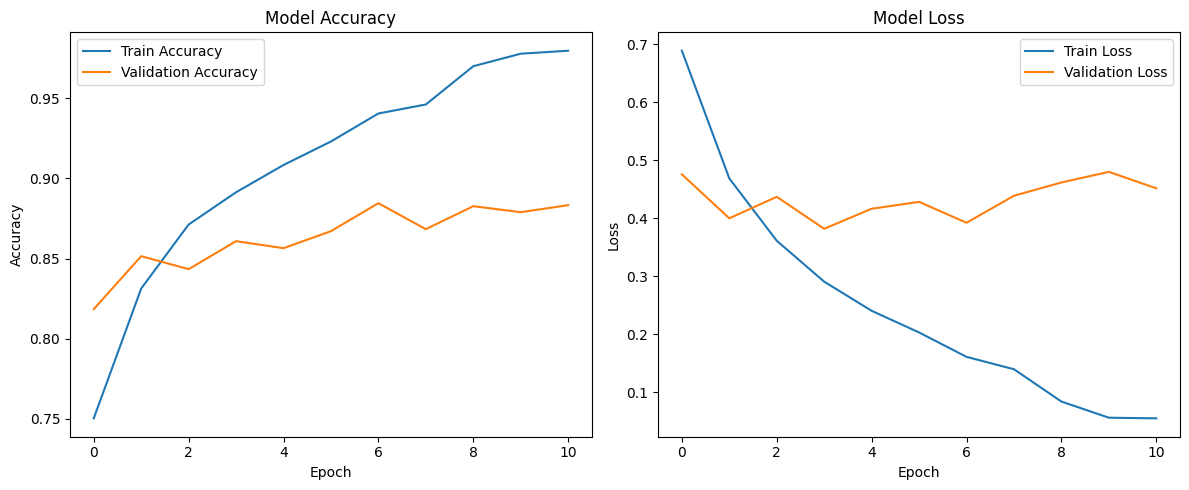

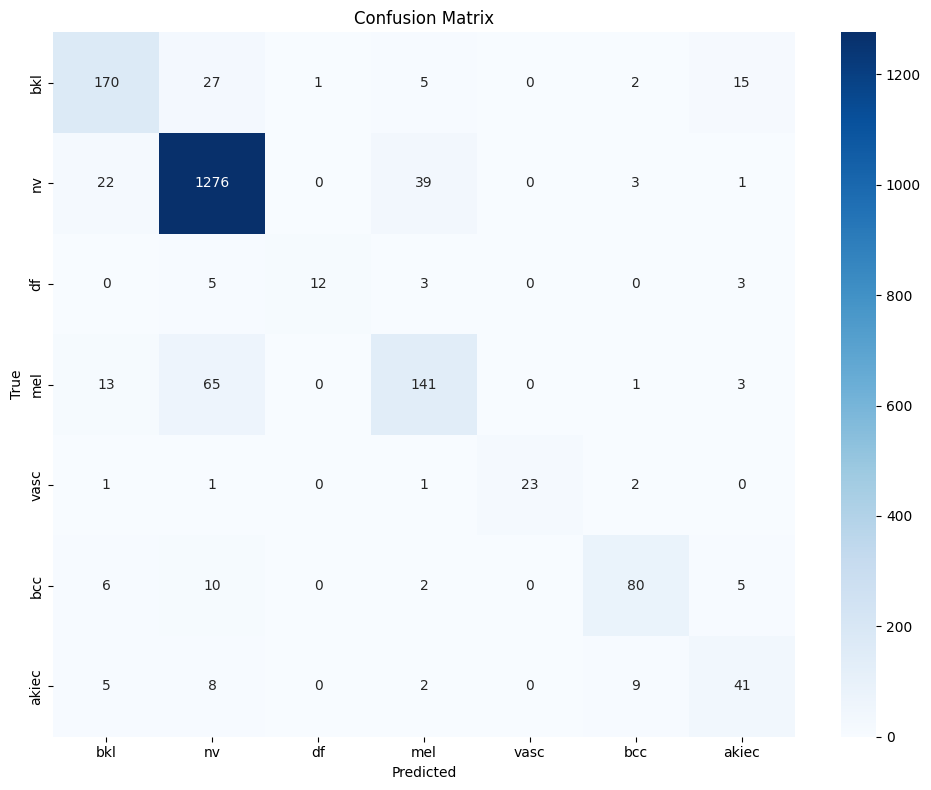

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, vit_b_16
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 16 # Reduced batch size for stability
EPOCHS = 100    # Reduced epochs to test functionality
LEARNING_RATE = 0.0001

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - using single-process loading for stability
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# Hybrid CNN-ViT Model
class SimplifiedHybridModel(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(SimplifiedHybridModel, self).__init__()

        # CNN Backbone - using EfficientNet-B0 for efficiency
        self.cnn = efficientnet_b0(pretrained=True)
        # Remove the classifier
        self.cnn_features = nn.Sequential(*list(self.cnn.children())[:-1])
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)

        # If you want to use ViT directly for feature extraction
        # (Simplified to avoid memory issues)
        self.vit = vit_b_16(pretrained=True)
        # Remove the classifier head
        self.vit.heads = nn.Identity()

        # Get feature dimensions
        cnn_out_features = 1280  # EfficientNet-B0
        vit_out_features = 768   # ViT-B/16

        # Simple fusion network
        self.fusion = nn.Sequential(
            nn.Linear(cnn_out_features + vit_out_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # Freeze early layers of both models to avoid overfitting
        # and reduce computational requirements
        # CNN: freeze first 3 blocks
        for name, param in list(self.cnn_features.named_parameters())[:70]:
            param.requires_grad = False

        # ViT: freeze transformer blocks except the last two
        for name, param in list(self.vit.named_parameters())[:-50]:
            param.requires_grad = False

    def forward(self, x):
        # CNN forward pass
        cnn_features = self.cnn_features(x)
        cnn_features = self.cnn_pool(cnn_features)
        cnn_features = torch.flatten(cnn_features, 1)

        # ViT forward pass
        vit_features = self.vit(x)

        # Concatenate features
        combined_features = torch.cat((cnn_features, vit_features), dim=1)

        # Feed through fusion network
        return self.fusion(combined_features)

# Function to print model summary
def print_model_summary(model, input_size=(3, 224, 224)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating model...")
model = SimplifiedHybridModel().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 7  # Number of epochs to wait for improvement
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_hybrid_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_hybrid_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'classification_report.txt'), 'w') as f:
        f.write(report)

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EfficientNetB1 + ViT

Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating EfficientNetB1 + ViT hybrid model...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:


Model Summary:
Total parameters: 95,113,487
Trainable parameters: 37,622,093
Non-trainable parameters: 57,491,394

Model Structure:
EfficientNetB1VitHybridModel(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(

Epoch 1 [Train]: 100%|██████████| 458/458 [20:20<00:00,  2.66s/it, loss=0.7920]


Train Loss: 0.8608 Acc: 0.7202


Epoch 1 [Val]: 100%|██████████| 115/115 [02:37<00:00,  1.37s/it, loss=0.4759]


Val Loss: 0.5378 Acc: 0.8260
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8260

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 458/458 [19:42<00:00,  2.58s/it, loss=0.5678]


Train Loss: 0.5535 Acc: 0.8051


Epoch 2 [Val]: 100%|██████████| 115/115 [02:28<00:00,  1.29s/it, loss=0.1563]


Val Loss: 0.4563 Acc: 0.8309
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8309

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 458/458 [19:40<00:00,  2.58s/it, loss=0.5678]


Train Loss: 0.4697 Acc: 0.8335


Epoch 3 [Val]: 100%|██████████| 115/115 [02:28<00:00,  1.29s/it, loss=0.1574]


Val Loss: 0.4754 Acc: 0.8359
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8359
Early stopping counter: 1/8

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 458/458 [19:39<00:00,  2.58s/it, loss=0.2993]


Train Loss: 0.3908 Acc: 0.8600


Epoch 4 [Val]: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it, loss=0.4597]


Val Loss: 0.4044 Acc: 0.8559
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8559

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 458/458 [20:00<00:00,  2.62s/it, loss=0.0517]


Train Loss: 0.3527 Acc: 0.8824


Epoch 5 [Val]: 100%|██████████| 115/115 [02:36<00:00,  1.36s/it, loss=0.3199]


Val Loss: 0.3961 Acc: 0.8621
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8621
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 458/458 [19:50<00:00,  2.60s/it, loss=0.2778]


Train Loss: 0.2999 Acc: 0.8983


Epoch 6 [Val]: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it, loss=0.1258]


Val Loss: 0.4350 Acc: 0.8559
Current learning rate: 0.0001000
Early stopping counter: 1/8

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 458/458 [19:38<00:00,  2.57s/it, loss=0.1122]


Train Loss: 0.2733 Acc: 0.9033


Epoch 7 [Val]: 100%|██████████| 115/115 [02:26<00:00,  1.28s/it, loss=0.2159]


Val Loss: 0.4013 Acc: 0.8696
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8696
Early stopping counter: 2/8

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 458/458 [19:35<00:00,  2.57s/it, loss=0.5732]


Train Loss: 0.2447 Acc: 0.9103


Epoch 8 [Val]: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it, loss=0.0228]


Val Loss: 0.4052 Acc: 0.8702
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8702
Early stopping counter: 3/8

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 458/458 [19:38<00:00,  2.57s/it, loss=0.1756]


Train Loss: 0.2153 Acc: 0.9282


Epoch 9 [Val]: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it, loss=0.0432]


Val Loss: 0.3879 Acc: 0.8796
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8796

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 458/458 [19:38<00:00,  2.57s/it, loss=0.1272]


Train Loss: 0.1929 Acc: 0.9374


Epoch 10 [Val]: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it, loss=0.0876]


Val Loss: 0.4338 Acc: 0.8715
Current learning rate: 0.0001000
Early stopping counter: 1/8
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 458/458 [19:23<00:00,  2.54s/it, loss=0.0691]


Train Loss: 0.1691 Acc: 0.9449


Epoch 11 [Val]: 100%|██████████| 115/115 [02:25<00:00,  1.26s/it, loss=0.0175]


Val Loss: 0.4211 Acc: 0.8802
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8802
Early stopping counter: 2/8

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 458/458 [19:20<00:00,  2.53s/it, loss=0.3842]


Train Loss: 0.1575 Acc: 0.9496


Epoch 12 [Val]: 100%|██████████| 115/115 [02:25<00:00,  1.26s/it, loss=0.0071]


Val Loss: 0.4120 Acc: 0.8827
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8827
Early stopping counter: 3/8

Epoch 13/100
------------------------------


Epoch 13 [Train]: 100%|██████████| 458/458 [19:22<00:00,  2.54s/it, loss=0.2237]


Train Loss: 0.1505 Acc: 0.9527


Epoch 13 [Val]: 100%|██████████| 115/115 [02:24<00:00,  1.26s/it, loss=0.0812]


Val Loss: 0.4311 Acc: 0.8752
Current learning rate: 0.0000500
Early stopping counter: 4/8

Epoch 14/100
------------------------------


Epoch 14 [Train]: 100%|██████████| 458/458 [19:22<00:00,  2.54s/it, loss=0.2534]


Train Loss: 0.0881 Acc: 0.9708


Epoch 14 [Val]: 100%|██████████| 115/115 [02:25<00:00,  1.27s/it, loss=0.0059]


Val Loss: 0.4593 Acc: 0.8840
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8840
Early stopping counter: 5/8

Epoch 15/100
------------------------------


Epoch 15 [Train]: 100%|██████████| 458/458 [19:26<00:00,  2.55s/it, loss=0.0022]


Train Loss: 0.0818 Acc: 0.9743


Epoch 15 [Val]: 100%|██████████| 115/115 [02:26<00:00,  1.27s/it, loss=0.1107]


Val Loss: 0.4511 Acc: 0.8815
Current learning rate: 0.0000500
Early stopping counter: 6/8
Checkpoint saved at epoch 15

Epoch 16/100
------------------------------


Epoch 16 [Train]: 100%|██████████| 458/458 [19:23<00:00,  2.54s/it, loss=0.7056]


Train Loss: 0.0556 Acc: 0.9824


Epoch 16 [Val]: 100%|██████████| 115/115 [02:25<00:00,  1.27s/it, loss=0.0015]


Val Loss: 0.4730 Acc: 0.8902
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8902
Early stopping counter: 7/8

Epoch 17/100
------------------------------


Epoch 17 [Train]: 100%|██████████| 458/458 [19:24<00:00,  2.54s/it, loss=0.0154]


Train Loss: 0.0573 Acc: 0.9819


Epoch 17 [Val]: 100%|██████████| 115/115 [02:25<00:00,  1.27s/it, loss=0.0217]


Val Loss: 0.4950 Acc: 0.8846
Current learning rate: 0.0000250
Early stopping counter: 8/8
Early stopping triggered after 17 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 144/144 [03:14<00:00,  1.35s/it]


Test Loss: 0.4717
Test Accuracy: 0.8892

Classification Report:
              precision    recall  f1-score   support

         bkl       0.79      0.82      0.81       220
          nv       0.94      0.96      0.95      1341
          df       0.81      0.57      0.67        23
         mel       0.75      0.73      0.74       223
        vasc       0.89      0.86      0.87        28
         bcc       0.80      0.80      0.80       103
       akiec       0.69      0.55      0.62        65

    accuracy                           0.89      2003
   macro avg       0.81      0.75      0.78      2003
weighted avg       0.89      0.89      0.89      2003

Evaluation complete!


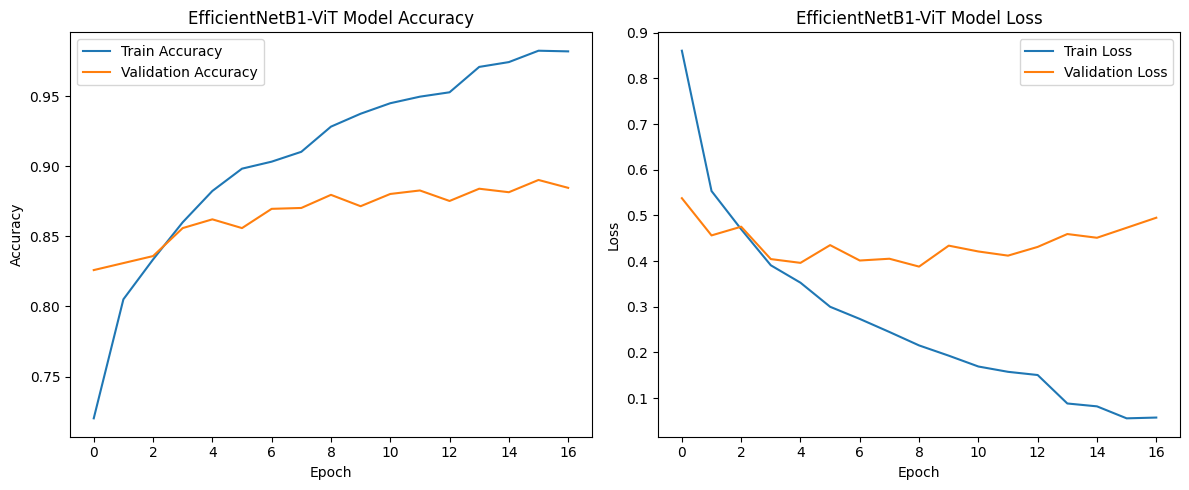

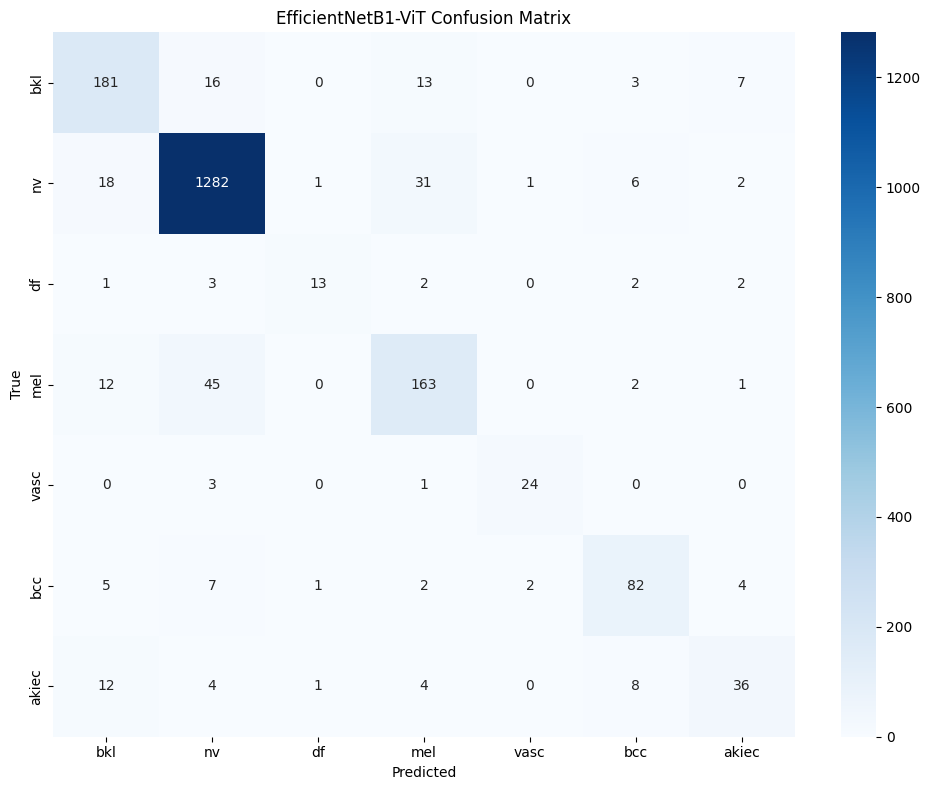

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b1, vit_b_16
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_efficientnetb1"  # Changed output directory for B1 model
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224  # Recommended size for EfficientNetB1 (between 224 for B0 and 260 for B2)
BATCH_SIZE = 14  # Adjusted batch size for B1 (between 16 for B0 and 12 for B2)
EPOCHS = 100
LEARNING_RATE = 0.0001

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations for EfficientNetB1
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),  # Added saturation jitter
    transforms.RandomAffine(degrees=0, translate=(0.04, 0.04)),  # Slight translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - using single-process loading for stability
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# EfficientNetB1 + ViT Hybrid Model
class EfficientNetB1VitHybridModel(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetB1VitHybridModel, self).__init__()

        # CNN Backbone - EfficientNet-B1
        self.cnn = efficientnet_b1(pretrained=True)
        # Remove the classifier
        self.cnn_features = nn.Sequential(*list(self.cnn.children())[:-1])
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)

        # Vision Transformer
        self.vit = vit_b_16(pretrained=True)
        # Remove the classifier head
        self.vit.heads = nn.Identity()

        # Get feature dimensions
        cnn_out_features = 1280  # EfficientNet-B1 output dimension
        vit_out_features = 768   # ViT-B/16 output dimension

        # Enhanced fusion network for B1
        self.fusion = nn.Sequential(
            nn.Linear(cnn_out_features + vit_out_features, 640),
            nn.BatchNorm1d(640),  # Added batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.35),  # Adjusted dropout for B1
            nn.Linear(640, 320),
            nn.BatchNorm1d(320),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(320, num_classes)
        )

        # Freeze early layers of both models to avoid overfitting
        # EfficientNet-B1: freeze first 3 blocks
        for name, param in list(self.cnn_features.named_parameters())[:75]:  # Adjusted for B1
            param.requires_grad = False

        # ViT: freeze transformer blocks except the last two
        for name, param in list(self.vit.named_parameters())[:-50]:
            param.requires_grad = False

    def forward(self, x):
        # CNN forward pass
        cnn_features = self.cnn_features(x)
        cnn_features = self.cnn_pool(cnn_features)
        cnn_features = torch.flatten(cnn_features, 1)

        # ViT forward pass
        vit_features = self.vit(x)

        # Concatenate features
        combined_features = torch.cat((cnn_features, vit_features), dim=1)

        # Feed through fusion network
        return self.fusion(combined_features)

# Function to print model summary
def print_model_summary(model, input_size=(3, 240, 240)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating EfficientNetB1 + ViT hybrid model...")
model = EfficientNetB1VitHybridModel().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=5e-6)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 8  # Adjusted patience for B1 (between 7 for B0 and 10 for B2)
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr:.7f}')

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_efficientnetb1_hybrid_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_efficientnetb1_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('EfficientNetB1-ViT Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB1-ViT Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb1_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_efficientnetb1_hybrid_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('EfficientNetB1-ViT Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb1_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'efficientnetb1_classification_report.txt'), 'w') as f:
        f.write(report)

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EfficientNetB2 + ViT

Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating EfficientNetB2 + ViT hybrid model...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:


Model Summary:
Total parameters: 96,880,881
Trainable parameters: 39,366,431
Non-trainable parameters: 57,514,450

Model Structure:
EfficientNetB2VitHybridModel(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(

Epoch 1 [Train]: 100%|██████████| 534/534 [20:17<00:00,  2.28s/it, loss=0.4190]


Train Loss: 0.7476 Acc: 0.7452


Epoch 1 [Val]: 100%|██████████| 133/133 [02:38<00:00,  1.19s/it, loss=0.7911]


Val Loss: 0.5361 Acc: 0.8095
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8095

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 534/534 [19:50<00:00,  2.23s/it, loss=0.9059]


Train Loss: 0.5094 Acc: 0.8205


Epoch 2 [Val]: 100%|██████████| 133/133 [02:30<00:00,  1.13s/it, loss=0.3593]


Val Loss: 0.4802 Acc: 0.8352
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8352

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 534/534 [19:50<00:00,  2.23s/it, loss=0.7001]


Train Loss: 0.4408 Acc: 0.8461


Epoch 3 [Val]: 100%|██████████| 133/133 [02:29<00:00,  1.13s/it, loss=0.4080]


Val Loss: 0.5032 Acc: 0.8346
Current learning rate: 0.0001000
Early stopping counter: 1/10

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 534/534 [19:53<00:00,  2.24s/it, loss=0.1733]


Train Loss: 0.3844 Acc: 0.8689


Epoch 4 [Val]: 100%|██████████| 133/133 [02:31<00:00,  1.14s/it, loss=0.4670]


Val Loss: 0.4504 Acc: 0.8509
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8509

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 534/534 [20:00<00:00,  2.25s/it, loss=0.0892]


Train Loss: 0.3225 Acc: 0.8845


Epoch 5 [Val]: 100%|██████████| 133/133 [02:32<00:00,  1.14s/it, loss=0.4276]


Val Loss: 0.4022 Acc: 0.8603
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8603
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 534/534 [20:09<00:00,  2.26s/it, loss=0.2597]


Train Loss: 0.2946 Acc: 0.8990


Epoch 6 [Val]: 100%|██████████| 133/133 [02:33<00:00,  1.15s/it, loss=0.5551]


Val Loss: 0.4877 Acc: 0.8546
Current learning rate: 0.0001000
Early stopping counter: 1/10

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 534/534 [20:12<00:00,  2.27s/it, loss=0.3853]


Train Loss: 0.2550 Acc: 0.9134


Epoch 7 [Val]: 100%|██████████| 133/133 [02:33<00:00,  1.16s/it, loss=0.3588]


Val Loss: 0.5496 Acc: 0.8446
Current learning rate: 0.0001000
Early stopping counter: 2/10

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 534/534 [21:00<00:00,  2.36s/it, loss=0.0299]


Train Loss: 0.2321 Acc: 0.9231


Epoch 8 [Val]: 100%|██████████| 133/133 [02:36<00:00,  1.18s/it, loss=0.8394]


Val Loss: 0.4051 Acc: 0.8759
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8759
Early stopping counter: 3/10

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 534/534 [21:01<00:00,  2.36s/it, loss=0.0125]


Train Loss: 0.2082 Acc: 0.9285


Epoch 9 [Val]: 100%|██████████| 133/133 [02:41<00:00,  1.22s/it, loss=1.4029]


Val Loss: 0.4523 Acc: 0.8747
Current learning rate: 0.0000500
Early stopping counter: 4/10

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 534/534 [20:58<00:00,  2.36s/it, loss=0.0068]


Train Loss: 0.1414 Acc: 0.9501


Epoch 10 [Val]: 100%|██████████| 133/133 [02:36<00:00,  1.17s/it, loss=1.1269]


Val Loss: 0.4948 Acc: 0.8853
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8853
Early stopping counter: 5/10
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 534/534 [20:45<00:00,  2.33s/it, loss=0.0098]


Train Loss: 0.1238 Acc: 0.9627


Epoch 11 [Val]: 100%|██████████| 133/133 [02:44<00:00,  1.24s/it, loss=1.2203]


Val Loss: 0.4659 Acc: 0.8878
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8878
Early stopping counter: 6/10

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 534/534 [21:37<00:00,  2.43s/it, loss=0.0295]


Train Loss: 0.1021 Acc: 0.9685


Epoch 12 [Val]: 100%|██████████| 133/133 [02:43<00:00,  1.23s/it, loss=0.4029]


Val Loss: 0.5458 Acc: 0.8791
Current learning rate: 0.0000500
Early stopping counter: 7/10

Epoch 13/100
------------------------------


Epoch 13 [Train]: 100%|██████████| 534/534 [21:12<00:00,  2.38s/it, loss=0.0420]


Train Loss: 0.0957 Acc: 0.9705


Epoch 13 [Val]: 100%|██████████| 133/133 [02:34<00:00,  1.16s/it, loss=1.0186]


Val Loss: 0.5471 Acc: 0.8935
Current learning rate: 0.0000250
New best model saved with accuracy: 0.8935
Early stopping counter: 8/10

Epoch 14/100
------------------------------


Epoch 14 [Train]: 100%|██████████| 534/534 [20:46<00:00,  2.34s/it, loss=0.1585]


Train Loss: 0.0676 Acc: 0.9802


Epoch 14 [Val]: 100%|██████████| 133/133 [02:38<00:00,  1.19s/it, loss=1.1745]


Val Loss: 0.5437 Acc: 0.8941
Current learning rate: 0.0000250
New best model saved with accuracy: 0.8941
Early stopping counter: 9/10

Epoch 15/100
------------------------------


Epoch 15 [Train]: 100%|██████████| 534/534 [20:57<00:00,  2.36s/it, loss=0.0040]


Train Loss: 0.0625 Acc: 0.9810


Epoch 15 [Val]: 100%|██████████| 133/133 [02:40<00:00,  1.21s/it, loss=1.1995]


Val Loss: 0.6008 Acc: 0.8866
Current learning rate: 0.0000250
Early stopping counter: 10/10
Early stopping triggered after 15 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 167/167 [03:23<00:00,  1.22s/it]


Test Loss: 0.6298
Test Accuracy: 0.8782

Classification Report:
              precision    recall  f1-score   support

         bkl       0.78      0.79      0.79       220
          nv       0.94      0.95      0.94      1341
          df       0.81      0.57      0.67        23
         mel       0.71      0.68      0.70       223
        vasc       0.93      0.93      0.93        28
         bcc       0.79      0.83      0.81       103
       akiec       0.67      0.57      0.62        65

    accuracy                           0.88      2003
   macro avg       0.80      0.76      0.78      2003
weighted avg       0.88      0.88      0.88      2003

Evaluation complete!


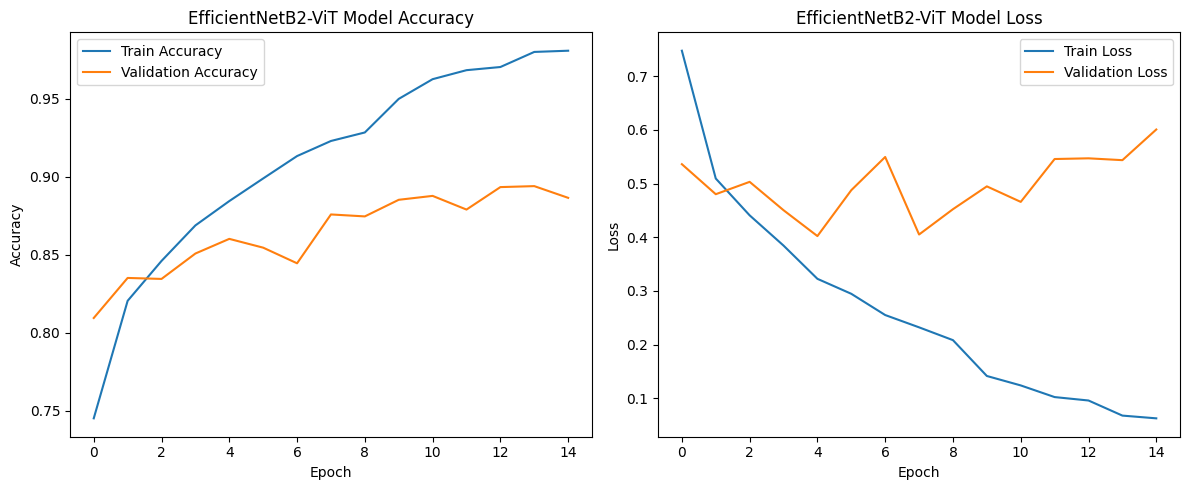

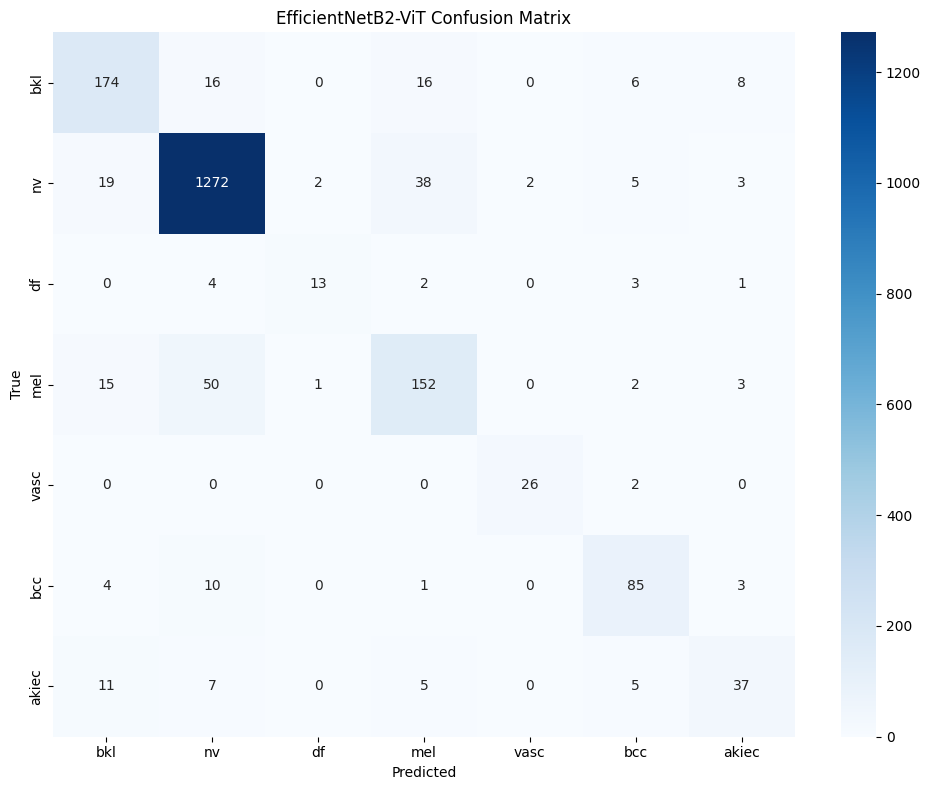

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b2, vit_b_16
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_efficientnetb2"  # Changed output directory for the new model
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224  # Increased image size for EfficientNetB2 (recommended is 260)
BATCH_SIZE = 12  # Reduced batch size due to larger model
EPOCHS = 100
LEARNING_RATE = 0.0001

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations - slightly enhanced for B2
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Added saturation jitter
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Added slight translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders with drop_last=True to prevent single-sample batches
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# EfficientNetB2 + ViT Hybrid Model
class EfficientNetB2VitHybridModel(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetB2VitHybridModel, self).__init__()

        # CNN Backbone - EfficientNet-B2
        self.cnn = efficientnet_b2(pretrained=True)
        # Remove the classifier
        self.cnn_features = nn.Sequential(*list(self.cnn.children())[:-1])
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)

        # Vision Transformer
        self.vit = vit_b_16(pretrained=True)
        # Remove the classifier head
        self.vit.heads = nn.Identity()

        # Get feature dimensions
        cnn_out_features = 1408  # EfficientNet-B2 output dimension
        vit_out_features = 768   # ViT-B/16 output dimension

        # Enhanced fusion network with group normalization instead of batch normalization
        self.fusion = nn.Sequential(
            nn.Linear(cnn_out_features + vit_out_features, 768),
            nn.GroupNorm(num_groups=32, num_channels=768),  # Replaced BatchNorm with GroupNorm
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(768, 384),
            nn.GroupNorm(num_groups=16, num_channels=384),  # Replaced BatchNorm with GroupNorm
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(384, num_classes)
        )

        # Freeze early layers of both models to avoid overfitting
        # EfficientNet-B2: freeze first 3 blocks
        for name, param in list(self.cnn_features.named_parameters())[:80]:  # Adjusted for B2
            param.requires_grad = False

        # ViT: freeze transformer blocks except the last two
        for name, param in list(self.vit.named_parameters())[:-50]:
            param.requires_grad = False

    def forward(self, x):
        # CNN forward pass
        cnn_features = self.cnn_features(x)
        cnn_features = self.cnn_pool(cnn_features)
        cnn_features = torch.flatten(cnn_features, 1)

        # ViT forward pass
        vit_features = self.vit(x)

        # Concatenate features
        combined_features = torch.cat((cnn_features, vit_features), dim=1)

        # Feed through fusion network
        return self.fusion(combined_features)

# Function to print model summary
def print_model_summary(model, input_size=(3, 260, 260)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating EfficientNetB2 + ViT hybrid model...")
model = EfficientNetB2VitHybridModel().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 10
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        processed_samples = 0  # Track actual number of processed samples

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            # Get batch size for this iteration
            current_batch_size = inputs.size(0)
            processed_samples += current_batch_size

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Statistics
            running_loss += loss.item() * current_batch_size
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Use actual processed samples instead of dataset length
        epoch_loss = running_loss / processed_samples
        epoch_acc = running_corrects.double() / processed_samples

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        val_processed_samples = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                current_batch_size = inputs.size(0)
                val_processed_samples += current_batch_size

                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * current_batch_size
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_val_loss = running_loss / val_processed_samples
        epoch_val_acc = running_corrects.double() / val_processed_samples

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr:.7f}')

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_efficientnetb2_hybrid_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_efficientnetb2_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('EfficientNetB2-ViT Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB2-ViT Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb2_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            current_batch_size = inputs.size(0)
            total_samples += current_batch_size

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * current_batch_size
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / total_samples
    test_acc = running_corrects.double() / total_samples

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_efficientnetb2_hybrid_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('EfficientNetB2-ViT Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb2_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'efficientnetb2_classification_report.txt'), 'w') as f:
        f.write(report)

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EfficientNetB3 + ViT

Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating EfficientNetB3 + ViT hybrid model...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:


Model Summary:
Total parameters: 101,053,719
Trainable parameters: 57,620,953
Non-trainable parameters: 43,432,766

Model Structure:
EfficientNetB3VitHybridModel(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride

Epoch 1 [Train]: 100%|██████████| 801/801 [24:58<00:00,  1.87s/it, loss=1.4610]


Train Loss: 1.2078 Acc: 0.6497 LR: 0.0000781


Epoch 1 [Val]: 100%|██████████| 200/200 [02:35<00:00,  1.28it/s, loss=1.0052]


Val Loss: 0.9338 Acc: 0.7867
New best model saved with accuracy: 0.7867

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 801/801 [24:59<00:00,  1.87s/it, loss=1.0102]


Train Loss: 1.0042 Acc: 0.7472 LR: 0.0000725


Epoch 2 [Val]: 100%|██████████| 200/200 [02:35<00:00,  1.28it/s, loss=0.9576]


Val Loss: 0.8741 Acc: 0.8016
New best model saved with accuracy: 0.8016

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 801/801 [25:08<00:00,  1.88s/it, loss=0.5625]


Train Loss: 0.9369 Acc: 0.7794 LR: 0.0000637


Epoch 3 [Val]: 100%|██████████| 200/200 [02:43<00:00,  1.22it/s, loss=0.9688]


Val Loss: 0.8296 Acc: 0.8160
New best model saved with accuracy: 0.8160

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 801/801 [25:19<00:00,  1.90s/it, loss=0.6616]


Train Loss: 0.8842 Acc: 0.8168 LR: 0.0000527


Epoch 4 [Val]: 100%|██████████| 200/200 [02:35<00:00,  1.29it/s, loss=0.9685]


Val Loss: 0.8056 Acc: 0.8322
New best model saved with accuracy: 0.8322

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 801/801 [24:59<00:00,  1.87s/it, loss=1.1830]


Train Loss: 0.8441 Acc: 0.8376 LR: 0.0000405


Epoch 5 [Val]: 100%|██████████| 200/200 [02:35<00:00,  1.28it/s, loss=1.0306]


Val Loss: 0.8061 Acc: 0.8497
New best model saved with accuracy: 0.8497
Early stopping counter: 1/12
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 801/801 [24:58<00:00,  1.87s/it, loss=0.5281]


Train Loss: 0.7785 Acc: 0.8689 LR: 0.0000283


Epoch 6 [Val]: 100%|██████████| 200/200 [02:35<00:00,  1.28it/s, loss=1.0269]


Val Loss: 0.8008 Acc: 0.8472

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 801/801 [24:57<00:00,  1.87s/it, loss=0.8772]


Train Loss: 0.7519 Acc: 0.8830 LR: 0.0000173


Epoch 7 [Val]: 100%|██████████| 200/200 [02:36<00:00,  1.28it/s, loss=1.0363]


Val Loss: 0.7723 Acc: 0.8684
New best model saved with accuracy: 0.8684

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 801/801 [24:59<00:00,  1.87s/it, loss=0.6751]


Train Loss: 0.6997 Acc: 0.9098 LR: 0.0000085


Epoch 8 [Val]: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s, loss=0.8945]


Val Loss: 0.7908 Acc: 0.8746
New best model saved with accuracy: 0.8746
Early stopping counter: 1/12

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 801/801 [25:00<00:00,  1.87s/it, loss=0.5660]


Train Loss: 0.6775 Acc: 0.9200 LR: 0.0000029


Epoch 9 [Val]: 100%|██████████| 200/200 [02:36<00:00,  1.28it/s, loss=1.0726]


Val Loss: 0.7826 Acc: 0.8802
New best model saved with accuracy: 0.8802
Early stopping counter: 2/12

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 801/801 [24:58<00:00,  1.87s/it, loss=0.4721]


Train Loss: 0.6597 Acc: 0.9304 LR: 0.0000800


Epoch 10 [Val]: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s, loss=1.1143]


Val Loss: 0.7712 Acc: 0.8777
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 801/801 [25:08<00:00,  1.88s/it, loss=0.6621]


Train Loss: 0.7597 Acc: 0.8828 LR: 0.0000795


Epoch 11 [Val]: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s, loss=1.1840]


Val Loss: 0.8314 Acc: 0.8515
Early stopping counter: 1/12

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 801/801 [25:33<00:00,  1.91s/it, loss=0.8448]


Train Loss: 0.7563 Acc: 0.8853 LR: 0.0000781


Epoch 12 [Val]: 100%|██████████| 200/200 [02:50<00:00,  1.18it/s, loss=1.8046]


Val Loss: 0.8767 Acc: 0.8391
Early stopping counter: 2/12

Epoch 13/100
------------------------------


Epoch 13 [Train]: 100%|██████████| 801/801 [26:51<00:00,  2.01s/it, loss=0.4866]


Train Loss: 0.7378 Acc: 0.8937 LR: 0.0000757


Epoch 13 [Val]: 100%|██████████| 200/200 [02:47<00:00,  1.20it/s, loss=1.1600]


Val Loss: 0.8352 Acc: 0.8615
Early stopping counter: 3/12

Epoch 14/100
------------------------------


Epoch 14 [Train]: 100%|██████████| 801/801 [26:36<00:00,  1.99s/it, loss=0.8365]


Train Loss: 0.7060 Acc: 0.9123 LR: 0.0000725


Epoch 14 [Val]: 100%|██████████| 200/200 [02:47<00:00,  1.19it/s, loss=1.5421]


Val Loss: 0.8566 Acc: 0.8546
Early stopping counter: 4/12

Epoch 15/100
------------------------------


Epoch 15 [Train]: 100%|██████████| 801/801 [25:00<00:00,  1.87s/it, loss=0.6702]


Train Loss: 0.6854 Acc: 0.9170 LR: 0.0000684


Epoch 15 [Val]: 100%|██████████| 200/200 [02:39<00:00,  1.26it/s, loss=1.7873]


Val Loss: 0.8851 Acc: 0.8546
Early stopping counter: 5/12
Checkpoint saved at epoch 15

Epoch 16/100
------------------------------


Epoch 16 [Train]: 100%|██████████| 801/801 [25:22<00:00,  1.90s/it, loss=0.5087]


Train Loss: 0.6769 Acc: 0.9237 LR: 0.0000637


Epoch 16 [Val]: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s, loss=1.2391]


Val Loss: 0.8687 Acc: 0.8459
Early stopping counter: 6/12

Epoch 17/100
------------------------------


Epoch 17 [Train]: 100%|██████████| 801/801 [25:30<00:00,  1.91s/it, loss=0.4564]


Train Loss: 0.6503 Acc: 0.9343 LR: 0.0000584


Epoch 17 [Val]: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s, loss=0.7679]


Val Loss: 0.8374 Acc: 0.8634
Early stopping counter: 7/12

Epoch 18/100
------------------------------


Epoch 18 [Train]: 100%|██████████| 801/801 [25:33<00:00,  1.91s/it, loss=0.4760]


Train Loss: 0.6299 Acc: 0.9421 LR: 0.0000527


Epoch 18 [Val]: 100%|██████████| 200/200 [02:42<00:00,  1.23it/s, loss=0.8288]


Val Loss: 0.8594 Acc: 0.8671
Early stopping counter: 8/12

Epoch 19/100
------------------------------


Epoch 19 [Train]: 100%|██████████| 801/801 [25:33<00:00,  1.91s/it, loss=0.4625]


Train Loss: 0.6097 Acc: 0.9505 LR: 0.0000467


Epoch 19 [Val]: 100%|██████████| 200/200 [02:40<00:00,  1.24it/s, loss=1.6657]


Val Loss: 0.8203 Acc: 0.8777
Early stopping counter: 9/12

Epoch 20/100
------------------------------


Epoch 20 [Train]: 100%|██████████| 801/801 [25:36<00:00,  1.92s/it, loss=0.4599]


Train Loss: 0.5925 Acc: 0.9566 LR: 0.0000405


Epoch 20 [Val]: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s, loss=1.2521]


Val Loss: 0.8170 Acc: 0.8827
New best model saved with accuracy: 0.8827
Early stopping counter: 10/12
Checkpoint saved at epoch 20

Epoch 21/100
------------------------------


Epoch 21 [Train]: 100%|██████████| 801/801 [25:40<00:00,  1.92s/it, loss=0.4756]


Train Loss: 0.5903 Acc: 0.9601 LR: 0.0000343


Epoch 21 [Val]: 100%|██████████| 200/200 [02:42<00:00,  1.23it/s, loss=1.1647]


Val Loss: 0.8444 Acc: 0.8752
Early stopping counter: 11/12

Epoch 22/100
------------------------------


Epoch 22 [Train]: 100%|██████████| 801/801 [25:39<00:00,  1.92s/it, loss=0.7593]


Train Loss: 0.5659 Acc: 0.9683 LR: 0.0000283


Epoch 22 [Val]: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s, loss=1.2384]


Val Loss: 0.8410 Acc: 0.8759
Early stopping counter: 12/12
Early stopping triggered after 22 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 251/251 [03:33<00:00,  1.18it/s]


Test Loss: 0.8466
Test Accuracy: 0.8717

Classification Report:
              precision    recall  f1-score   support

         bkl       0.73      0.75      0.74       220
          nv       0.93      0.95      0.94      1341
          df       0.86      0.52      0.65        23
         mel       0.75      0.69      0.72       223
        vasc       1.00      0.79      0.88        28
         bcc       0.83      0.77      0.80       103
       akiec       0.55      0.60      0.57        65

    accuracy                           0.87      2003
   macro avg       0.81      0.72      0.76      2003
weighted avg       0.87      0.87      0.87      2003


Analyzing 5 most confident misclassifications:
Error during evaluation: single positional indexer is out-of-bounds


Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_19020\143743462.py", line 549, in <module>
    print(f"- Image {test_df.iloc[test_idx]['image_id']}: True class: {true_class}, "
                     ~~~~~~~~~~~~^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1192, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1753, in _getitem_axis
    self._validate_integer(key, axis)
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py", line 1686, in _vali

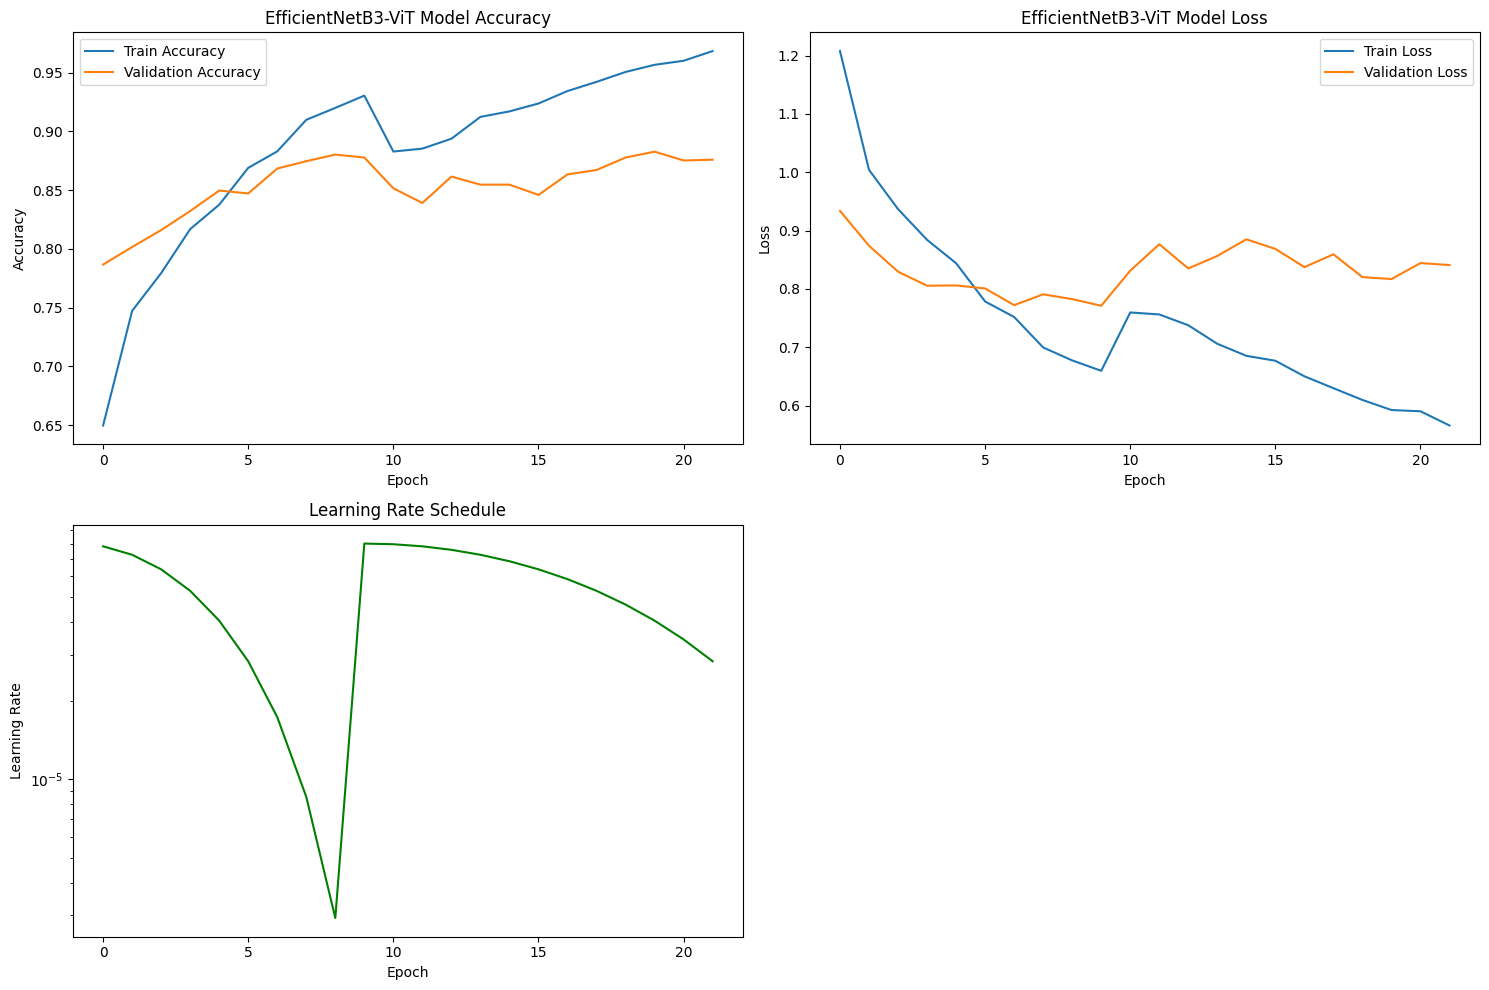

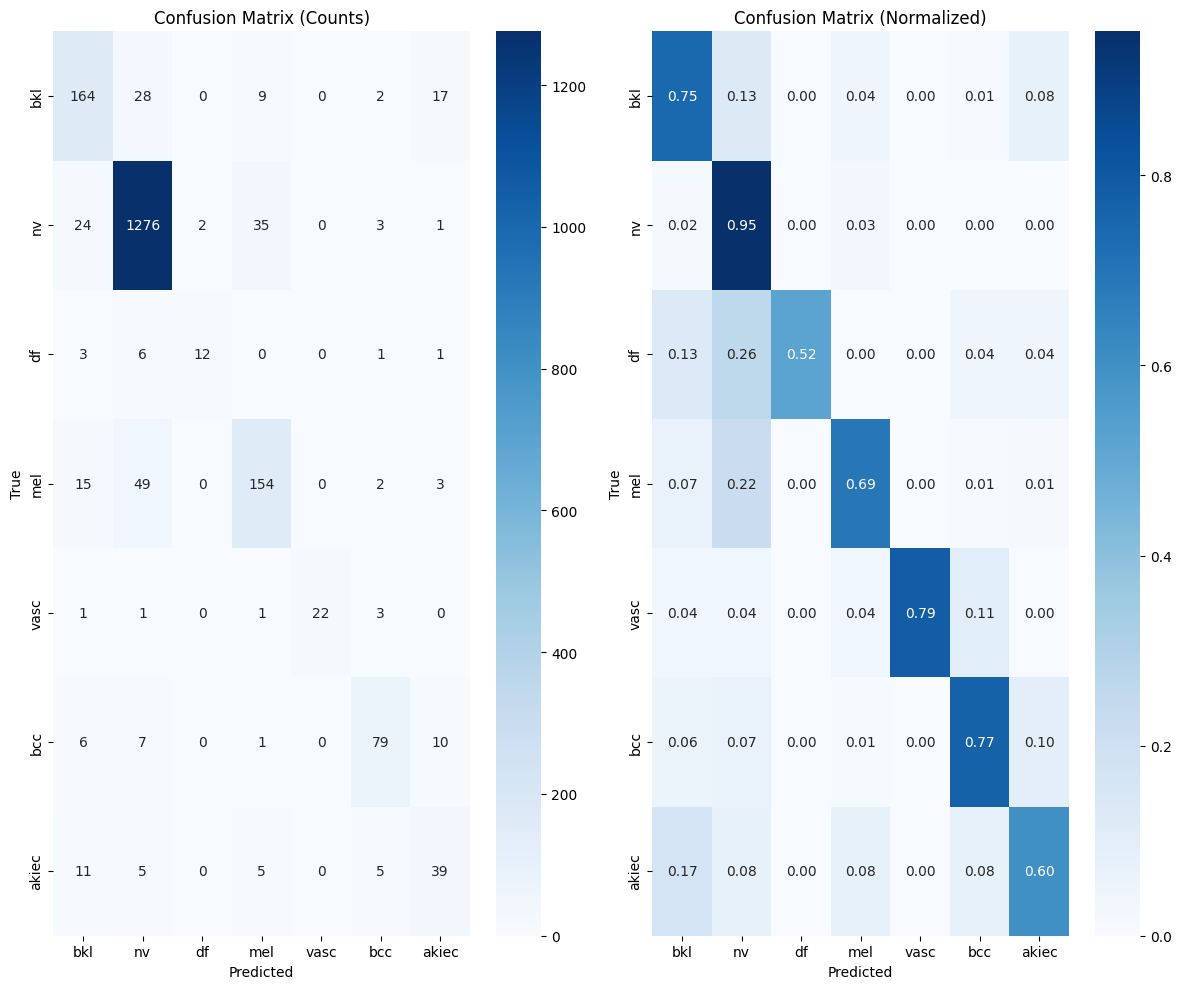

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b3, vit_b_16
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_efficientnetb3"  # Changed output directory for B3 model
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224  # Recommended size for EfficientNetB3
BATCH_SIZE = 8   # Reduced batch size for the larger model
EPOCHS = 100
LEARNING_RATE = 0.00008  # Slightly lower learning rate for larger model

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations for EfficientNetB3 - enhanced augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Light blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - using drop_last=True to prevent BatchNorm errors with batches of size 1
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# EfficientNetB3 + ViT Hybrid Model
class EfficientNetB3VitHybridModel(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetB3VitHybridModel, self).__init__()

        # CNN Backbone - EfficientNet-B3
        self.cnn = efficientnet_b3(pretrained=True)
        # Remove the classifier
        self.cnn_features = nn.Sequential(*list(self.cnn.children())[:-1])
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)

        # Vision Transformer
        self.vit = vit_b_16(pretrained=True)
        # Remove the classifier head
        self.vit.heads = nn.Identity()

        # Get feature dimensions
        cnn_out_features = 1536  # EfficientNet-B3 output dimension
        vit_out_features = 768   # ViT-B/16 output dimension

        # Enhanced fusion network for B3 with more layers and regularization
        self.fusion = nn.Sequential(
            nn.Linear(cnn_out_features + vit_out_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Higher dropout for the larger model
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Freeze early layers of both models to avoid overfitting
        # EfficientNet-B3: freeze early blocks
        for name, param in list(self.cnn_features.named_parameters())[:100]:  # Adjusted for B3
            param.requires_grad = False

        # ViT: freeze transformer blocks except the last three
        for name, param in list(self.vit.named_parameters())[:-75]:
            param.requires_grad = False

    def forward(self, x):
        # CNN forward pass
        cnn_features = self.cnn_features(x)
        cnn_features = self.cnn_pool(cnn_features)
        cnn_features = torch.flatten(cnn_features, 1)

        # ViT forward pass
        vit_features = self.vit(x)

        # Concatenate features
        combined_features = torch.cat((cnn_features, vit_features), dim=1)

        # Check if we're in training mode and have a batch size of 1
        if self.training and combined_features.size(0) == 1:
            # Switch to eval mode temporarily just for this forward pass
            self.fusion.eval()
            output = self.fusion(combined_features)
            self.fusion.train()
            return output
        else:
            # Normal forward pass
            return self.fusion(combined_features)

# Function to print model summary
def print_model_summary(model, input_size=(3, 300, 300)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating EfficientNetB3 + ViT hybrid model...")
model = EfficientNetB3VitHybridModel().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer with more aggressive weight decay for B3
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Added label smoothing for regularization
optimizer = optim.AdamW(  # Using AdamW for better weight decay handling
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

# More advanced scheduler for B3
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Restart every 10 epochs
    T_mult=2,  # Double the restart interval after each restart
    eta_min=1e-6  # Minimum learning rate
)

# Training function with early stopping and mixed precision
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    # Early stopping parameters
    patience = 12  # Increased patience for the larger model
    counter = 0
    best_val_loss = float('inf')

    # Mixed precision setup
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # Backward and optimize with scaler
                scaler.scale(loss).backward()
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard precision training
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Update learning rate before validation (for cosine annealing)
        if isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
            scheduler.step(epoch + 1)

        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {current_lr:.7f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Use mixed precision for validation as well if available
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler if using ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_efficientnetb3_hybrid_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_efficientnetb3_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history with learning rate
    plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('EfficientNetB3-ViT Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB3-ViT Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history['lr'], label='Learning Rate', color='green')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb3_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Enhanced evaluation function with metrics and visualization
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []  # Store probabilities for ROC curve

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Use mixed precision for evaluation if available
            if device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels, all_probs

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_efficientnetb3_hybrid_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    # Run evaluation
    test_loss, test_acc, all_preds, all_labels, all_probs = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix with improved visualization
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))

    # Normalize confusion matrix for percentage view
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot both raw counts and normalized percentages
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Counts)')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb3_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'efficientnetb3_classification_report.txt'), 'w') as f:
        f.write(report)

    # Additional: Top misclassifications analysis
    misclassified_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]

    if len(misclassified_indices) > 0:
        print(f"\nAnalyzing {min(5, len(misclassified_indices))} most confident misclassifications:")

        # Convert test_dataset to a list for easier indexing
        test_indices = test_df.index.tolist()

        for i in range(min(5, len(misclassified_indices))):
            idx = misclassified_indices[i]
            test_idx = test_indices[idx % len(test_indices)]
            true_class = CLASS_NAMES[all_labels[idx]]
            pred_class = CLASS_NAMES[all_preds[idx]]
            confidence = all_probs[idx][all_preds[idx]]

            print(f"- Image {test_df.iloc[test_idx]['image_id']}: True class: {true_class}, "
                  f"Predicted as: {pred_class}, Confidence: {confidence:.4f}")

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EfficientNetB0

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating EfficientNetB0 model...

Model Summary:
Total parameters: 4,016,515
Trainable parameters: 3,707,855
Non-trainable parameters: 308,660

Model Structure:
EfficientNetB0Model(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=

Epoch 1 [Train]: 100%|██████████| 401/401 [03:13<00:00,  2.08it/s, loss=0.4697]


Train Loss: 0.8437 Acc: 0.7182


Epoch 1 [Val]: 100%|██████████| 101/101 [00:32<00:00,  3.10it/s, loss=0.5689]


Val Loss: 0.5605 Acc: 0.8047
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8047

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 401/401 [03:05<00:00,  2.16it/s, loss=1.2003]


Train Loss: 0.5722 Acc: 0.7900


Epoch 2 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.25it/s, loss=0.1101]


Val Loss: 0.4879 Acc: 0.8203
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8203

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 401/401 [03:03<00:00,  2.18it/s, loss=0.6208]


Train Loss: 0.5046 Acc: 0.8199


Epoch 3 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.25it/s, loss=0.1583]


Val Loss: 0.4361 Acc: 0.8472
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8472

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 401/401 [03:03<00:00,  2.18it/s, loss=0.2072]


Train Loss: 0.4423 Acc: 0.8338


Epoch 4 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.24it/s, loss=0.1714]


Val Loss: 0.4444 Acc: 0.8384
Current learning rate: 0.0001000
Early stopping counter: 1/7

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 401/401 [03:03<00:00,  2.19it/s, loss=0.6913]


Train Loss: 0.4000 Acc: 0.8530


Epoch 5 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, loss=0.0652]


Val Loss: 0.4608 Acc: 0.8440
Current learning rate: 0.0001000
Early stopping counter: 2/7
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 401/401 [03:04<00:00,  2.17it/s, loss=0.5908]


Train Loss: 0.3639 Acc: 0.8683


Epoch 6 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.25it/s, loss=0.3513]


Val Loss: 0.4387 Acc: 0.8490
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8490
Early stopping counter: 3/7

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 401/401 [03:04<00:00,  2.18it/s, loss=0.3413]


Train Loss: 0.3209 Acc: 0.8822


Epoch 7 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.27it/s, loss=0.1722]


Val Loss: 0.4504 Acc: 0.8515
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8515
Early stopping counter: 4/7

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 401/401 [03:03<00:00,  2.18it/s, loss=0.1803]


Train Loss: 0.2749 Acc: 0.9008


Epoch 8 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, loss=0.2141]


Val Loss: 0.4059 Acc: 0.8653
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8653

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 401/401 [03:04<00:00,  2.18it/s, loss=0.1013]


Train Loss: 0.2517 Acc: 0.9104


Epoch 9 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, loss=0.6466]


Val Loss: 0.4294 Acc: 0.8646
Current learning rate: 0.0000500
Early stopping counter: 1/7

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 401/401 [03:03<00:00,  2.18it/s, loss=0.2624]


Train Loss: 0.2384 Acc: 0.9098


Epoch 10 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.27it/s, loss=0.5443]


Val Loss: 0.4210 Acc: 0.8677
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8677
Early stopping counter: 2/7
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 401/401 [03:04<00:00,  2.17it/s, loss=0.2352]


Train Loss: 0.2274 Acc: 0.9120


Epoch 11 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, loss=0.3669]


Val Loss: 0.4443 Acc: 0.8553
Current learning rate: 0.0000500
Early stopping counter: 3/7

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 401/401 [03:03<00:00,  2.18it/s, loss=0.4466]


Train Loss: 0.2114 Acc: 0.9249


Epoch 12 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.25it/s, loss=0.0913]


Val Loss: 0.4631 Acc: 0.8671
Current learning rate: 0.0000250
Early stopping counter: 4/7

Epoch 13/100
------------------------------


Epoch 13 [Train]: 100%|██████████| 401/401 [03:04<00:00,  2.18it/s, loss=0.5524]


Train Loss: 0.1850 Acc: 0.9354


Epoch 13 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, loss=0.2105]


Val Loss: 0.4291 Acc: 0.8709
Current learning rate: 0.0000250
New best model saved with accuracy: 0.8709
Early stopping counter: 5/7

Epoch 14/100
------------------------------


Epoch 14 [Train]: 100%|██████████| 401/401 [03:04<00:00,  2.18it/s, loss=0.0439]


Train Loss: 0.1837 Acc: 0.9332


Epoch 14 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, loss=0.3160]


Val Loss: 0.4337 Acc: 0.8784
Current learning rate: 0.0000250
New best model saved with accuracy: 0.8784
Early stopping counter: 6/7

Epoch 15/100
------------------------------


Epoch 15 [Train]: 100%|██████████| 401/401 [03:04<00:00,  2.18it/s, loss=0.0297]


Train Loss: 0.1843 Acc: 0.9343


Epoch 15 [Val]: 100%|██████████| 101/101 [00:23<00:00,  4.25it/s, loss=0.3332]


Val Loss: 0.4912 Acc: 0.8721
Current learning rate: 0.0000250
Early stopping counter: 7/7
Early stopping triggered after 15 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]


Test Loss: 0.4803
Test Accuracy: 0.8502

Classification Report:
              precision    recall  f1-score   support

         bkl       0.73      0.77      0.75       220
          nv       0.92      0.93      0.93      1341
          df       0.68      0.57      0.62        23
         mel       0.65      0.65      0.65       223
        vasc       0.74      0.82      0.78        28
         bcc       0.72      0.77      0.75       103
       akiec       0.69      0.48      0.56        65

    accuracy                           0.85      2003
   macro avg       0.74      0.71      0.72      2003
weighted avg       0.85      0.85      0.85      2003

Evaluation complete!


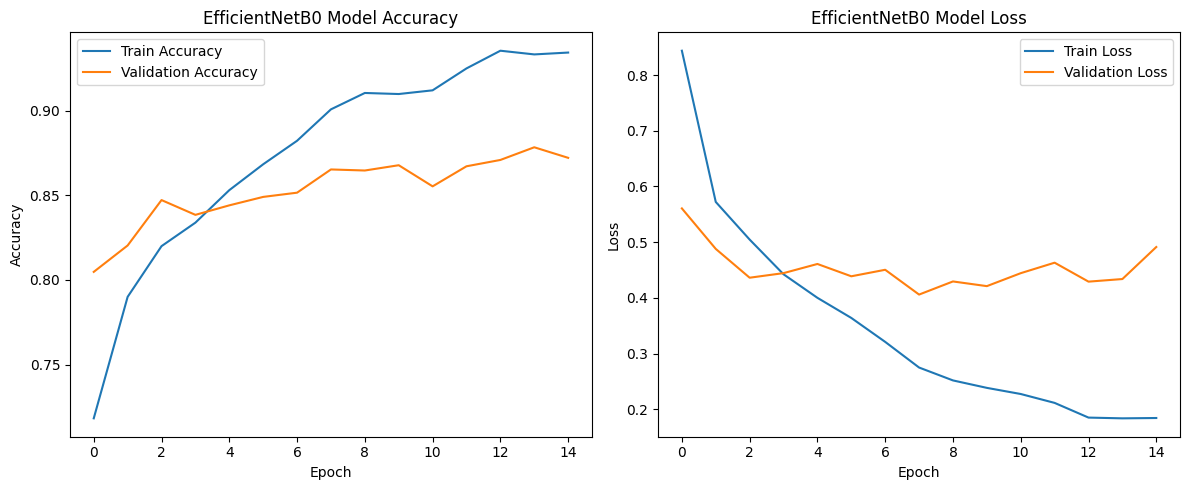

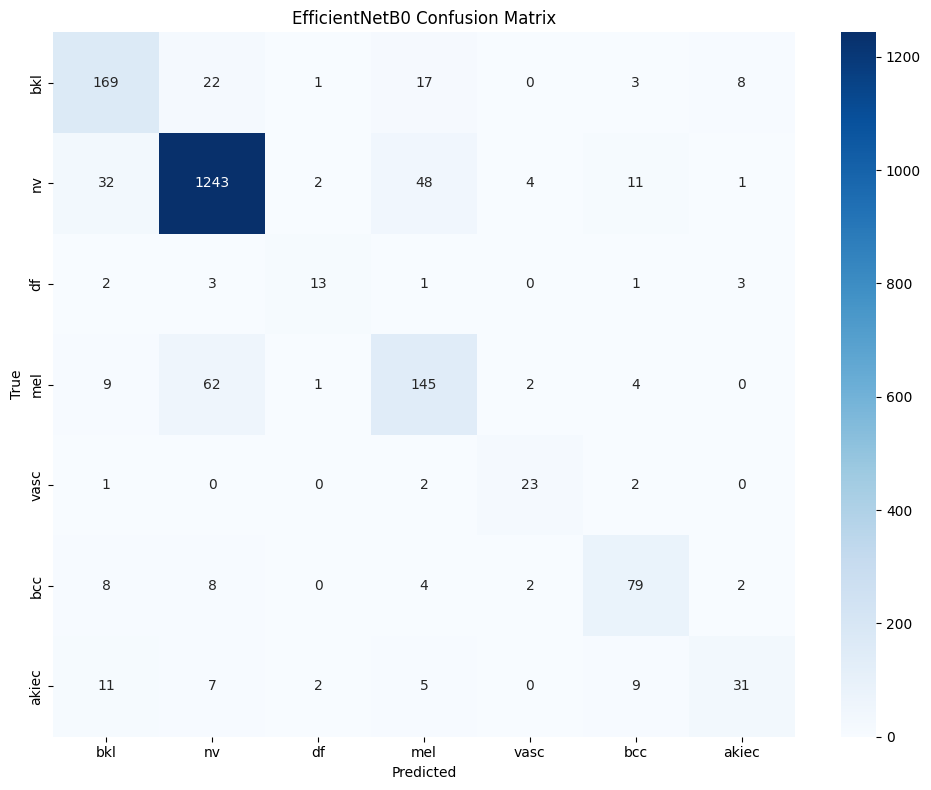

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_efficientnetb0"  # Output directory for B0 model
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224  # Recommended size for EfficientNetB0
BATCH_SIZE = 16  # Standard batch size for B0
EPOCHS = 100
LEARNING_RATE = 0.0001

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations for EfficientNetB0
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.04, 0.04)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - using single-process loading for stability
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# EfficientNetB0 Model
class EfficientNetB0Model(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetB0Model, self).__init__()

        # Load pre-trained EfficientNet-B0
        self.efficientnet = efficientnet_b0(pretrained=True)

        # Get the number of features in the last layer
        num_features = self.efficientnet.classifier[1].in_features

        # Replace the classifier with our own
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, num_classes)
        )

        # Freeze early layers of the network to avoid overfitting
        # Only train the last 4 blocks
        freeze_layers = list(self.efficientnet.features.named_children())[:-4]
        for name, param in freeze_layers:
            for param in self.efficientnet.features._modules[name].parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

# Function to print model summary
def print_model_summary(model, input_size=(3, 224, 224)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating EfficientNetB0 model...")
model = EfficientNetB0Model().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=5e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 7  # Patience for B0
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr:.7f}')

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_efficientnetb0_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_efficientnetb0_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('EfficientNetB0 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB0 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb0_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_efficientnetb0_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('EfficientNetB0 Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb0_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'efficientnetb0_classification_report.txt'), 'w') as f:
        f.write(report)

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EfficientNetB1

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating EfficientNetB1 model...

Model Summary:
Total parameters: 7,172,647
Trainable parameters: 6,718,475
Non-trainable parameters: 454,172

Model Structure:
EfficientNetB1Model(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=

Epoch 1 [Train]: 100%|██████████| 458/458 [04:39<00:00,  1.64it/s, loss=0.8442]


Train Loss: 0.8167 Acc: 0.7156


Epoch 1 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.38it/s, loss=0.5643]


Val Loss: 0.6567 Acc: 0.7760
Current learning rate: 0.0001000
New best model saved with accuracy: 0.7760

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.1952]


Train Loss: 0.5739 Acc: 0.7965


Epoch 2 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, loss=0.2664]


Val Loss: 0.5349 Acc: 0.8110
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8110

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 458/458 [04:39<00:00,  1.64it/s, loss=0.4766]


Train Loss: 0.4902 Acc: 0.8256


Epoch 3 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, loss=0.2810]


Val Loss: 0.4806 Acc: 0.8297
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8297

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.6777]


Train Loss: 0.4417 Acc: 0.8391


Epoch 4 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.40it/s, loss=0.4643]


Val Loss: 0.4738 Acc: 0.8166
Current learning rate: 0.0001000

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.3020]


Train Loss: 0.3898 Acc: 0.8597


Epoch 5 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, loss=0.3777]


Val Loss: 0.4661 Acc: 0.8503
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8503
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.3844]


Train Loss: 0.3554 Acc: 0.8692


Epoch 6 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, loss=0.0563]


Val Loss: 0.4319 Acc: 0.8403
Current learning rate: 0.0001000

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.0207]


Train Loss: 0.3265 Acc: 0.8813


Epoch 7 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.38it/s, loss=0.1643]


Val Loss: 0.4208 Acc: 0.8553
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8553

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 458/458 [04:39<00:00,  1.64it/s, loss=0.5009]


Train Loss: 0.2875 Acc: 0.8969


Epoch 8 [Val]: 100%|██████████| 115/115 [00:34<00:00,  3.38it/s, loss=0.1737]


Val Loss: 0.4817 Acc: 0.8497
Current learning rate: 0.0001000
Early stopping counter: 1/8

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 458/458 [04:39<00:00,  1.64it/s, loss=0.1134]


Train Loss: 0.2623 Acc: 0.9073


Epoch 9 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, loss=0.2843]


Val Loss: 0.4907 Acc: 0.8465
Current learning rate: 0.0001000
Early stopping counter: 2/8

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.1480]


Train Loss: 0.2578 Acc: 0.9064


Epoch 10 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, loss=0.3909]


Val Loss: 0.4743 Acc: 0.8497
Current learning rate: 0.0001000
Early stopping counter: 3/8
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.0786]


Train Loss: 0.2268 Acc: 0.9184


Epoch 11 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.40it/s, loss=1.0270]


Val Loss: 0.5372 Acc: 0.8372
Current learning rate: 0.0000500
Early stopping counter: 4/8

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.2993]


Train Loss: 0.2013 Acc: 0.9334


Epoch 12 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.40it/s, loss=0.2778]


Val Loss: 0.5705 Acc: 0.8484
Current learning rate: 0.0000500
Early stopping counter: 5/8

Epoch 13/100
------------------------------


Epoch 13 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.6113]


Train Loss: 0.1687 Acc: 0.9432


Epoch 13 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, loss=0.3377]


Val Loss: 0.5839 Acc: 0.8465
Current learning rate: 0.0000500
Early stopping counter: 6/8

Epoch 14/100
------------------------------


Epoch 14 [Train]: 100%|██████████| 458/458 [04:38<00:00,  1.64it/s, loss=0.0878]


Train Loss: 0.1774 Acc: 0.9420


Epoch 14 [Val]: 100%|██████████| 115/115 [00:34<00:00,  3.37it/s, loss=0.0178]


Val Loss: 0.5238 Acc: 0.8571
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8571
Early stopping counter: 7/8

Epoch 15/100
------------------------------


Epoch 15 [Train]: 100%|██████████| 458/458 [04:39<00:00,  1.64it/s, loss=0.0274]


Train Loss: 0.1381 Acc: 0.9494


Epoch 15 [Val]: 100%|██████████| 115/115 [00:33<00:00,  3.40it/s, loss=0.0662]


Val Loss: 0.5677 Acc: 0.8578
Current learning rate: 0.0000250
New best model saved with accuracy: 0.8578
Early stopping counter: 8/8
Early stopping triggered after 15 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 144/144 [00:42<00:00,  3.39it/s]


Test Loss: 0.5340
Test Accuracy: 0.8707

Classification Report:
              precision    recall  f1-score   support

         bkl       0.71      0.80      0.75       220
          nv       0.95      0.93      0.94      1341
          df       0.87      0.57      0.68        23
         mel       0.68      0.73      0.70       223
        vasc       0.79      0.79      0.79        28
         bcc       0.76      0.83      0.80       103
       akiec       0.79      0.63      0.70        65

    accuracy                           0.87      2003
   macro avg       0.79      0.75      0.77      2003
weighted avg       0.88      0.87      0.87      2003

Evaluation complete!


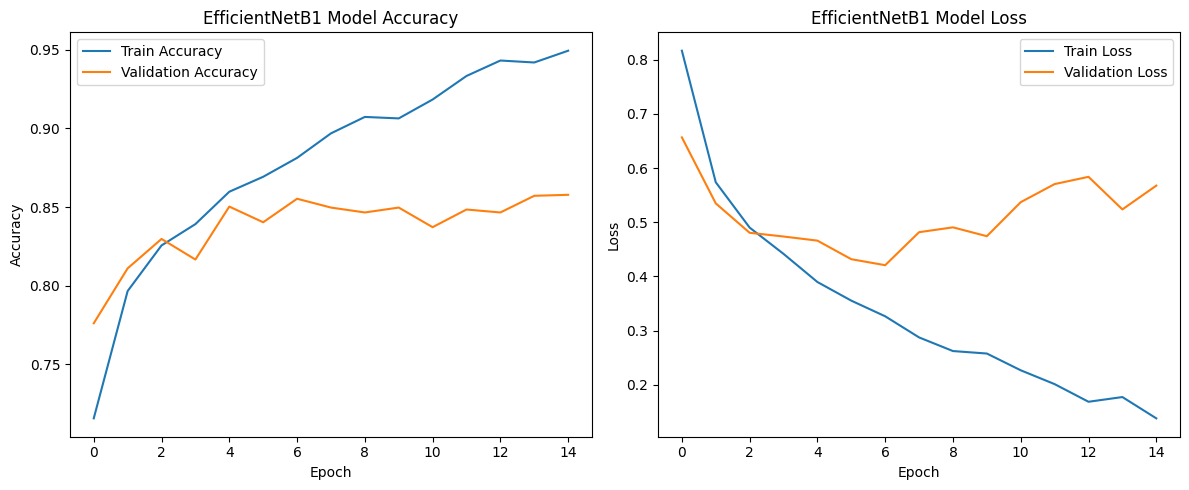

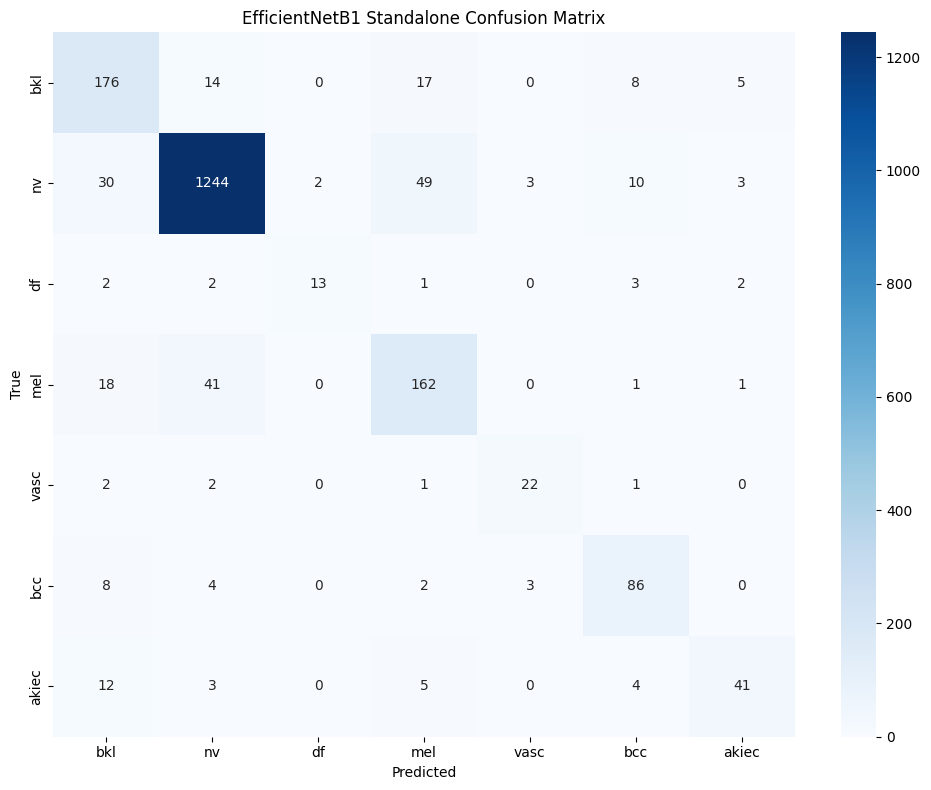

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b1
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_efficientnetb1_standalone"  # Output directory for standalone B1 model
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters - adjusted for EfficientNetB1
IMG_SIZE = 240  # Recommended size for EfficientNetB1
BATCH_SIZE = 14  # Standard batch size for B1 (smaller than B0)
EPOCHS = 100
LEARNING_RATE = 0.0001

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations for EfficientNetB1
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),  # Added saturation jitter
    transforms.RandomAffine(degrees=0, translate=(0.04, 0.04)),  # Slight translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - using single-process loading for stability
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# EfficientNetB1 Model
class EfficientNetB1Model(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetB1Model, self).__init__()

        # Load pre-trained EfficientNet-B1
        self.efficientnet = efficientnet_b1(pretrained=True)

        # Get the number of features in the last layer
        num_features = self.efficientnet.classifier[1].in_features

        # Replace the classifier with our own - slightly more complex for B1
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.25),  # Slightly higher dropout for B1
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

        # Freeze early layers of the network to avoid overfitting
        # Only train the last 4 blocks for B1
        freeze_layers = list(self.efficientnet.features.named_children())[:-4]
        for name, param in freeze_layers:
            for param in self.efficientnet.features._modules[name].parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

# Function to print model summary
def print_model_summary(model, input_size=(3, 240, 240)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating EfficientNetB1 model...")
model = EfficientNetB1Model().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=5e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 8  # Patience for B1 (slightly higher than B0)
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr:.7f}')

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_efficientnetb1_standalone_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_efficientnetb1_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('EfficientNetB1 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB1 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb1_standalone_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_efficientnetb1_standalone_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('EfficientNetB1 Standalone Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb1_standalone_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'efficientnetb1_standalone_classification_report.txt'), 'w') as f:
        f.write(report)

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EfficientNetB2

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating EfficientNetB2 model...

Model Summary:
Total parameters: 9,083,401
Trainable parameters: 8,949,855
Non-trainable parameters: 133,546

Model Structure:
EfficientNetB2Model(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=

Epoch 1 [Train]: 100%|██████████| 534/534 [08:00<00:00,  1.11it/s, loss=1.0394]


Train Loss: 0.7807 Acc: 0.7296


Epoch 1 [Val]: 100%|██████████| 133/133 [00:56<00:00,  2.33it/s, loss=0.3867]


Val Loss: 0.5586 Acc: 0.7882
Current learning rate: 0.0001000
New best model saved with accuracy: 0.7882

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 534/534 [06:42<00:00,  1.33it/s, loss=0.7943]


Train Loss: 0.5724 Acc: 0.7935


Epoch 2 [Val]: 100%|██████████| 133/133 [00:42<00:00,  3.10it/s, loss=0.4731]


Val Loss: 0.4803 Acc: 0.8214
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8214

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 534/534 [07:15<00:00,  1.23it/s, loss=0.1280]


Train Loss: 0.4719 Acc: 0.8268


Epoch 3 [Val]: 100%|██████████| 133/133 [00:47<00:00,  2.79it/s, loss=0.2295]


Val Loss: 0.4913 Acc: 0.8264
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8264
Early stopping counter: 1/10

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 534/534 [07:20<00:00,  1.21it/s, loss=0.0749]


Train Loss: 0.4296 Acc: 0.8511


Epoch 4 [Val]: 100%|██████████| 133/133 [00:47<00:00,  2.80it/s, loss=0.7820]


Val Loss: 0.4876 Acc: 0.8390
Current learning rate: 0.0001000
New best model saved with accuracy: 0.8390
Early stopping counter: 2/10

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 534/534 [07:19<00:00,  1.22it/s, loss=0.1257]


Train Loss: 0.3791 Acc: 0.8691


Epoch 5 [Val]: 100%|██████████| 133/133 [00:47<00:00,  2.80it/s, loss=0.5542]


Val Loss: 0.5085 Acc: 0.8321
Current learning rate: 0.0001000
Early stopping counter: 3/10
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 534/534 [07:22<00:00,  1.21it/s, loss=0.3656]


Train Loss: 0.3394 Acc: 0.8752


Epoch 6 [Val]: 100%|██████████| 133/133 [00:47<00:00,  2.82it/s, loss=0.4363]


Val Loss: 0.5410 Acc: 0.8402
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8402
Early stopping counter: 4/10

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 534/534 [07:09<00:00,  1.24it/s, loss=0.2543]


Train Loss: 0.2633 Acc: 0.9093


Epoch 7 [Val]: 100%|██████████| 133/133 [00:45<00:00,  2.91it/s, loss=0.6237]


Val Loss: 0.5250 Acc: 0.8340
Current learning rate: 0.0000500
Early stopping counter: 5/10

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 534/534 [07:06<00:00,  1.25it/s, loss=0.0863]


Train Loss: 0.2297 Acc: 0.9196


Epoch 8 [Val]: 100%|██████████| 133/133 [00:46<00:00,  2.88it/s, loss=0.8433]


Val Loss: 0.4819 Acc: 0.8640
Current learning rate: 0.0000500
New best model saved with accuracy: 0.8640
Early stopping counter: 6/10

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 534/534 [07:16<00:00,  1.22it/s, loss=0.0541]


Train Loss: 0.2164 Acc: 0.9265


Epoch 9 [Val]: 100%|██████████| 133/133 [00:48<00:00,  2.72it/s, loss=0.9565]


Val Loss: 0.5176 Acc: 0.8615
Current learning rate: 0.0000500
Early stopping counter: 7/10

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 534/534 [07:17<00:00,  1.22it/s, loss=0.2401]


Train Loss: 0.2146 Acc: 0.9302


Epoch 10 [Val]: 100%|██████████| 133/133 [00:42<00:00,  3.12it/s, loss=1.2973]


Val Loss: 0.5214 Acc: 0.8647
Current learning rate: 0.0000250
New best model saved with accuracy: 0.8647
Early stopping counter: 8/10
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 534/534 [06:40<00:00,  1.33it/s, loss=0.3571]


Train Loss: 0.1675 Acc: 0.9451


Epoch 11 [Val]: 100%|██████████| 133/133 [00:42<00:00,  3.11it/s, loss=1.1216]


Val Loss: 0.5309 Acc: 0.8622
Current learning rate: 0.0000250
Early stopping counter: 9/10

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 534/534 [06:41<00:00,  1.33it/s, loss=0.0075]


Train Loss: 0.1546 Acc: 0.9529


Epoch 12 [Val]: 100%|██████████| 133/133 [00:42<00:00,  3.12it/s, loss=0.4763]


Val Loss: 0.5340 Acc: 0.8722
Current learning rate: 0.0000250
New best model saved with accuracy: 0.8722
Early stopping counter: 10/10
Early stopping triggered after 12 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 166/166 [01:04<00:00,  2.57it/s]


Test Loss: 0.5396
Test Accuracy: 0.8750

Classification Report:
              precision    recall  f1-score   support

         bkl       0.78      0.73      0.76       217
          nv       0.93      0.95      0.94      1333
          df       1.00      0.43      0.61        23
         mel       0.73      0.67      0.70       223
        vasc       0.83      0.86      0.84        28
         bcc       0.74      0.84      0.79       103
       akiec       0.71      0.63      0.67        65

    accuracy                           0.88      1992
   macro avg       0.82      0.73      0.76      1992
weighted avg       0.87      0.88      0.87      1992

Evaluation complete!


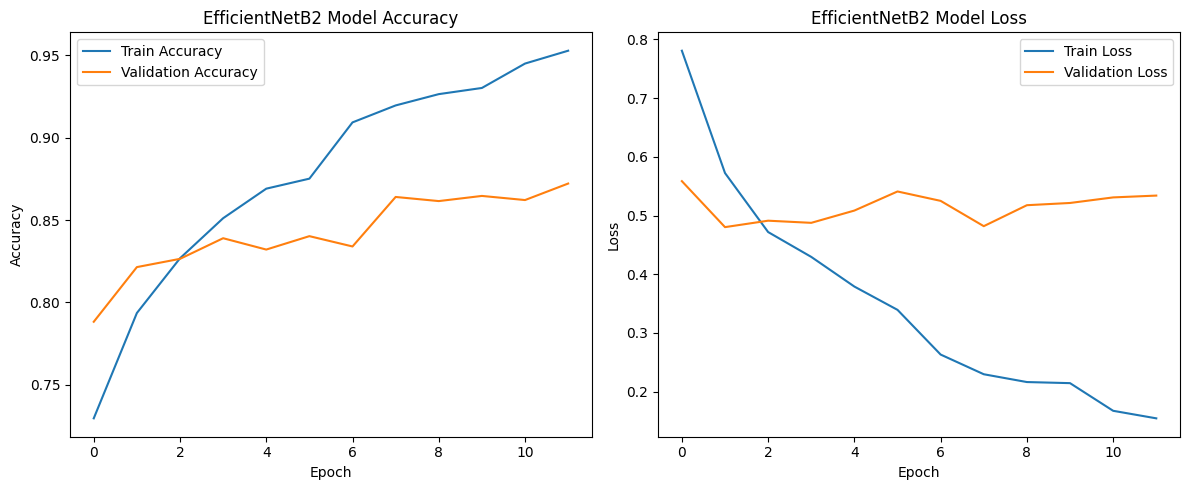

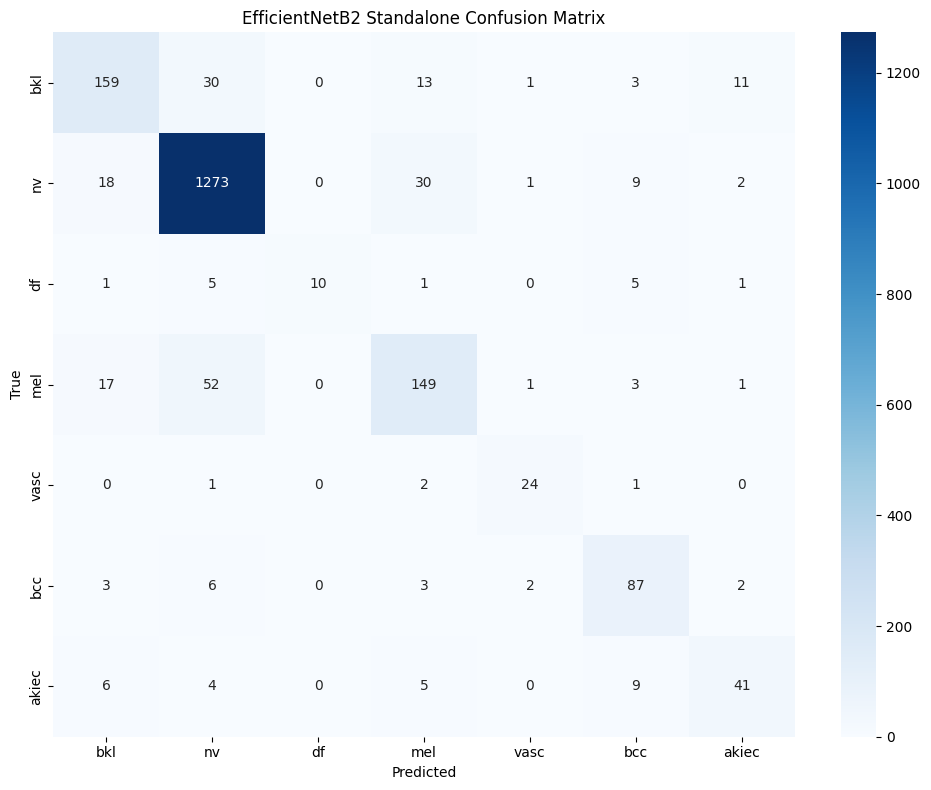

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_efficientnetb2_standalone"  # Output directory for standalone B2 model
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters - adjusted for EfficientNetB2
IMG_SIZE = 260  # Recommended size for EfficientNetB2
BATCH_SIZE = 12  # Standard batch size for B2 (smaller than B1)
EPOCHS = 100
LEARNING_RATE = 0.0001

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations for EfficientNetB2
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Increased saturation jitter for B2
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Increased translation for B2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - using drop_last=True to avoid the error with small batch sizes
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
print("Dataloaders created")

# Modified EfficientNetB2 Model with LayerNorm instead of BatchNorm
class EfficientNetB2Model(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetB2Model, self).__init__()

        # Load pre-trained EfficientNet-B2
        self.efficientnet = efficientnet_b2(pretrained=True)

        # Get the number of features in the last layer
        num_features = self.efficientnet.classifier[1].in_features

        # Replace the classifier with our own - using LayerNorm instead of BatchNorm
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.3),  # Higher dropout for B2
            nn.Linear(num_features, 768),  # Larger hidden layer for B2
            nn.LayerNorm(768),  # Changed from BatchNorm to LayerNorm
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(768, 384),
            nn.LayerNorm(384),  # Changed from BatchNorm to LayerNorm
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(384, num_classes)
        )

        # Freeze early layers of the network to avoid overfitting
        # Only train the last 5 blocks for B2 (more layers than B0/B1)
        freeze_layers = list(self.efficientnet.features.named_children())[:-5]
        for name, param in freeze_layers:
            for param in self.efficientnet.features._modules[name].parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

# Function to print model summary
def print_model_summary(model, input_size=(3, 260, 260)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating EfficientNetB2 model...")
model = EfficientNetB2Model().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=6e-6)  # Increased weight decay for B2
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Training function with early stopping and batch size protection
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 10  # Increased patience for B2
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        samples_count = 0  # To track actual number of processed samples

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            # Skip very small batches - additional safety check
            if inputs.size(0) <= 1:
                print(f"Skipping batch with size {inputs.size(0)}")
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.size(0)  # Get actual batch size
            samples_count += batch_size

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Statistics
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Calculate epoch stats based on actual processed samples
        if samples_count > 0:  # Safety check
            epoch_loss = running_loss / samples_count
            epoch_acc = running_corrects.double() / samples_count
        else:
            epoch_loss = float('inf')
            epoch_acc = 0.0

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        samples_count = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                # Skip very small batches
                if inputs.size(0) <= 1:
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)
                batch_size = inputs.size(0)
                samples_count += batch_size

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        if samples_count > 0:  # Safety check
            epoch_val_loss = running_loss / samples_count
            epoch_val_acc = running_corrects.double() / samples_count
        else:
            epoch_val_loss = float('inf')
            epoch_val_acc = 0.0

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr:.7f}')

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_efficientnetb2_standalone_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_efficientnetb2_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('EfficientNetB2 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB2 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb2_standalone_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Modified evaluation function to handle small batches
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    samples_count = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            # Skip very small batches
            if inputs.size(0) <= 1:
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.size(0)
            samples_count += batch_size

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if samples_count > 0:  # Safety check
        test_loss = running_loss / samples_count
        test_acc = running_corrects.double() / samples_count
    else:
        test_loss = float('inf')
        test_acc = 0.0

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_efficientnetb2_standalone_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('EfficientNetB2 Standalone Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb2_standalone_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'efficientnetb2_standalone_classification_report.txt'), 'w') as f:
        f.write(report)

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EfficientNetB3

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating EfficientNetB3 model...

Model Summary:
Total parameters: 12,801,583
Trainable parameters: 12,748,801
Non-trainable parameters: 52,782

Model Structure:
EfficientNetB3Model(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum

Epoch 1 [Train]: 100%|██████████| 801/801 [13:12<00:00,  1.01it/s, loss=0.6041]


Train Loss: 0.8744 Acc: 0.6945


Epoch 1 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.85it/s, loss=0.4997]


Val Loss: 0.6309 Acc: 0.7823
Current learning rate: 0.0000800
New best model saved with accuracy: 0.7823

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 801/801 [12:52<00:00,  1.04it/s, loss=1.3084]


Train Loss: 0.6481 Acc: 0.7695


Epoch 2 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.85it/s, loss=0.0978]


Val Loss: 0.5047 Acc: 0.8210
Current learning rate: 0.0000800
New best model saved with accuracy: 0.8210

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 801/801 [12:52<00:00,  1.04it/s, loss=0.7966]


Train Loss: 0.5717 Acc: 0.8067


Epoch 3 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.85it/s, loss=0.2094]


Val Loss: 0.5258 Acc: 0.8153
Current learning rate: 0.0000800
Early stopping counter: 1/12

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 801/801 [12:52<00:00,  1.04it/s, loss=0.4962]


Train Loss: 0.5038 Acc: 0.8234


Epoch 4 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0536]


Val Loss: 0.4369 Acc: 0.8447
Current learning rate: 0.0000800
New best model saved with accuracy: 0.8447

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 801/801 [12:50<00:00,  1.04it/s, loss=0.4742]


Train Loss: 0.4755 Acc: 0.8384


Epoch 5 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.85it/s, loss=0.7493]


Val Loss: 0.4269 Acc: 0.8465
Current learning rate: 0.0000800
New best model saved with accuracy: 0.8465
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 801/801 [12:49<00:00,  1.04it/s, loss=0.1436]


Train Loss: 0.4256 Acc: 0.8526


Epoch 6 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0341]


Val Loss: 0.4133 Acc: 0.8715
Current learning rate: 0.0000800
New best model saved with accuracy: 0.8715

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 801/801 [12:49<00:00,  1.04it/s, loss=0.0856]


Train Loss: 0.3885 Acc: 0.8702


Epoch 7 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.85it/s, loss=0.1560]


Val Loss: 0.4349 Acc: 0.8546
Current learning rate: 0.0000800
Early stopping counter: 1/12

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 801/801 [12:52<00:00,  1.04it/s, loss=0.6942]


Train Loss: 0.3672 Acc: 0.8758


Epoch 8 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0115]


Val Loss: 0.4628 Acc: 0.8740
Current learning rate: 0.0000800
New best model saved with accuracy: 0.8740
Early stopping counter: 2/12

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 801/801 [12:51<00:00,  1.04it/s, loss=0.5614]


Train Loss: 0.3589 Acc: 0.8867


Epoch 9 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.3537]


Val Loss: 0.4633 Acc: 0.8709
Current learning rate: 0.0000800
Early stopping counter: 3/12

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 801/801 [12:51<00:00,  1.04it/s, loss=0.0058]


Train Loss: 0.3244 Acc: 0.8950


Epoch 10 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0048]


Val Loss: 0.4406 Acc: 0.8790
Current learning rate: 0.0000800
New best model saved with accuracy: 0.8790
Early stopping counter: 4/12
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 801/801 [12:49<00:00,  1.04it/s, loss=0.3102]


Train Loss: 0.2884 Acc: 0.9100


Epoch 11 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.87it/s, loss=0.0105]


Val Loss: 0.4664 Acc: 0.8734
Current learning rate: 0.0000400
Early stopping counter: 5/12

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 801/801 [12:50<00:00,  1.04it/s, loss=0.1452]


Train Loss: 0.2378 Acc: 0.9251


Epoch 12 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.85it/s, loss=0.0066]


Val Loss: 0.4478 Acc: 0.8796
Current learning rate: 0.0000400
New best model saved with accuracy: 0.8796
Early stopping counter: 6/12

Epoch 13/100
------------------------------


Epoch 13 [Train]: 100%|██████████| 801/801 [12:51<00:00,  1.04it/s, loss=0.0136]


Train Loss: 0.2213 Acc: 0.9310


Epoch 13 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0292]


Val Loss: 0.4493 Acc: 0.8833
Current learning rate: 0.0000400
New best model saved with accuracy: 0.8833
Early stopping counter: 7/12

Epoch 14/100
------------------------------


Epoch 14 [Train]: 100%|██████████| 801/801 [12:51<00:00,  1.04it/s, loss=0.9171]


Train Loss: 0.2158 Acc: 0.9373


Epoch 14 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0117]


Val Loss: 0.5163 Acc: 0.8821
Current learning rate: 0.0000400
Early stopping counter: 8/12

Epoch 15/100
------------------------------


Epoch 15 [Train]: 100%|██████████| 801/801 [12:51<00:00,  1.04it/s, loss=0.0796]


Train Loss: 0.2066 Acc: 0.9410


Epoch 15 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.85it/s, loss=0.0172]


Val Loss: 0.4753 Acc: 0.8784
Current learning rate: 0.0000400
Early stopping counter: 9/12
Checkpoint saved at epoch 15

Epoch 16/100
------------------------------


Epoch 16 [Train]: 100%|██████████| 801/801 [12:50<00:00,  1.04it/s, loss=0.6412]


Train Loss: 0.1954 Acc: 0.9430


Epoch 16 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.1325]


Val Loss: 0.4600 Acc: 0.8827
Current learning rate: 0.0000200
Early stopping counter: 10/12

Epoch 17/100
------------------------------


Epoch 17 [Train]: 100%|██████████| 801/801 [12:50<00:00,  1.04it/s, loss=0.0119]


Train Loss: 0.1739 Acc: 0.9509


Epoch 17 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0655]


Val Loss: 0.4888 Acc: 0.8846
Current learning rate: 0.0000200
New best model saved with accuracy: 0.8846
Early stopping counter: 11/12

Epoch 18/100
------------------------------


Epoch 18 [Train]: 100%|██████████| 801/801 [12:49<00:00,  1.04it/s, loss=0.8817]


Train Loss: 0.1537 Acc: 0.9565


Epoch 18 [Val]: 100%|██████████| 201/201 [01:10<00:00,  2.86it/s, loss=0.0209]


Val Loss: 0.4930 Acc: 0.8777
Current learning rate: 0.0000200
Early stopping counter: 12/12
Early stopping triggered after 18 epochs
Training history plotted and saved
Loading best model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 251/251 [01:28<00:00,  2.84it/s]


Test Loss: 0.4412
Test Accuracy: 0.8872

Classification Report:
              precision    recall  f1-score   support

         bkl       0.80      0.77      0.78       220
          nv       0.94      0.96      0.95      1341
          df       0.81      0.57      0.67        23
         mel       0.73      0.71      0.72       223
        vasc       0.89      0.86      0.87        28
         bcc       0.90      0.78      0.83       103
       akiec       0.67      0.75      0.71        65

    accuracy                           0.89      2003
   macro avg       0.82      0.77      0.79      2003
weighted avg       0.89      0.89      0.89      2003

Evaluation complete!


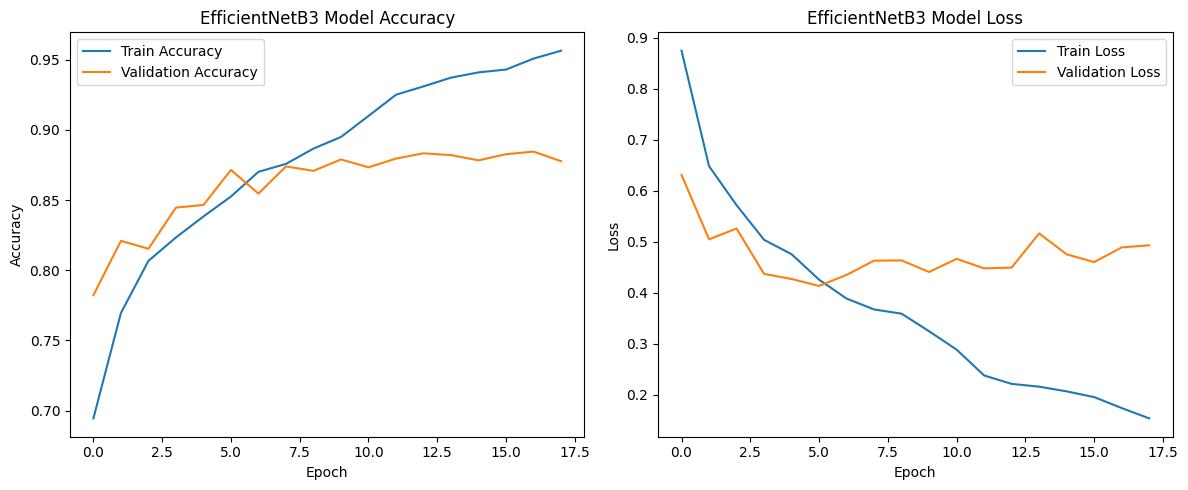

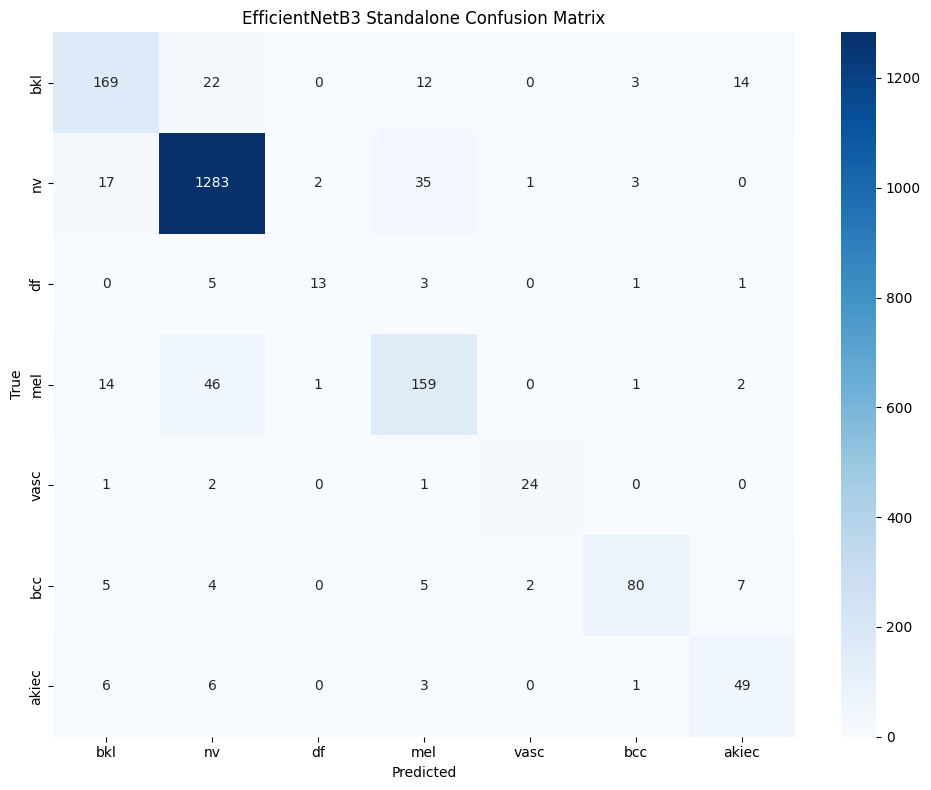

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b3
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_efficientnetb3_standalone"  # Output directory for standalone B3 model
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters - adjusted for EfficientNetB3
IMG_SIZE = 300  # Recommended size for EfficientNetB3 (larger than B2)
BATCH_SIZE = 8  # Smaller batch size due to larger model
EPOCHS = 100
LEARNING_RATE = 0.00008  # Slightly lower learning rate for the larger model

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations for EfficientNetB3
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.15),  # Increased saturation jitter for B3
    transforms.RandomAffine(degrees=0, translate=(0.06, 0.06)),  # Increased translation for B3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - FIX: Add drop_last=True to train_loader to avoid the BatchNorm issue
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# EfficientNetB3 Model
class EfficientNetB3Model(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(EfficientNetB3Model, self).__init__()

        # Load pre-trained EfficientNet-B3
        self.efficientnet = efficientnet_b3(pretrained=True)

        # Get the number of features in the last layer
        num_features = self.efficientnet.classifier[1].in_features

        # Replace the classifier with our own - more complex for B3
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.35),  # Higher dropout for B3
            nn.Linear(num_features, 1024),  # Larger hidden layer for B3
            nn.BatchNorm1d(1024, momentum=0.01),  # Added batch norm with lower momentum for stability
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512, momentum=0.01),  # Lower momentum
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )

        # Freeze early layers of the network to avoid overfitting
        # Only train the last 6 blocks for B3 (more layers than B2)
        freeze_layers = list(self.efficientnet.features.named_children())[:-6]
        for name, param in freeze_layers:
            for param in self.efficientnet.features._modules[name].parameters():
                param.requires_grad = False

    def forward(self, x):
        # FIX: Handle the last batch issue with a try-except block
        try:
            return self.efficientnet(x)
        except ValueError as e:
            # If we encounter a batch size of 1, use eval mode for batch norm
            if "Expected more than 1 value per channel when training" in str(e):
                was_training = self.training
                if was_training:
                    self.eval()  # Temporarily switch to eval mode
                    with torch.no_grad():
                        output = self.efficientnet(x)
                    self.train()  # Switch back to training mode
                    return output
                else:
                    # If already in eval mode, re-raise the exception
                    raise e
            else:
                # If it's a different error, re-raise it
                raise e

# Function to print model summary
def print_model_summary(model, input_size=(3, 300, 300)):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating EfficientNetB3 model...")
model = EfficientNetB3Model().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=8e-6)  # Increased weight decay for B3
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=5e-7)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 12  # Increased patience for B3
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                try:
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    val_bar.set_postfix(loss=f"{loss.item():.4f}")
                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    # Skip this batch and continue with the next
                    continue

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr:.7f}')

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_efficientnetb3_standalone_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_efficientnetb3_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('EfficientNetB3 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('EfficientNetB3 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb3_standalone_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            try:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"Error in test batch: {e}")
                # Skip this batch and continue with the next
                continue

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_efficientnetb3_standalone_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('EfficientNetB3 Standalone Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'efficientnetb3_standalone_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'efficientnetb3_standalone_classification_report.txt'), 'w') as f:
        f.write(report)

    print("Evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

ViT

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: cpu
Loading metadata...
Found 10015 images with 7 classes: bkl, nv, df, mel, vasc, bcc, akiec
Training set: 6409 images
Validation set: 1603 images
Test set: 2003 images
Creating datasets...
Dataloaders created
Creating ViT model...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Model Summary:
Total parameters: 85,804,039
Trainable parameters: 28,356,871
Non-trainable parameters: 57,447,168

Model Structure:
ViTSkinCancerModel(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias

Epoch 1 [Train]: 100%|██████████| 401/401 [15:29<00:00,  2.32s/it, loss=0.2667]


Train Loss: 0.6578 Acc: 0.7636


Epoch 1 [Val]: 100%|██████████| 101/101 [02:17<00:00,  1.36s/it, loss=0.8205]


Val Loss: 0.5187 Acc: 0.8022
New best model saved with accuracy: 0.8022

Epoch 2/100
------------------------------


Epoch 2 [Train]: 100%|██████████| 401/401 [14:53<00:00,  2.23s/it, loss=0.1790]


Train Loss: 0.4568 Acc: 0.8293


Epoch 2 [Val]: 100%|██████████| 101/101 [02:09<00:00,  1.28s/it, loss=1.7840]


Val Loss: 0.5487 Acc: 0.7948
Early stopping counter: 1/7

Epoch 3/100
------------------------------


Epoch 3 [Train]: 100%|██████████| 401/401 [14:52<00:00,  2.23s/it, loss=0.2717]


Train Loss: 0.3721 Acc: 0.8647


Epoch 3 [Val]: 100%|██████████| 101/101 [02:08<00:00,  1.27s/it, loss=0.9485]


Val Loss: 0.4342 Acc: 0.8359
New best model saved with accuracy: 0.8359

Epoch 4/100
------------------------------


Epoch 4 [Train]: 100%|██████████| 401/401 [14:52<00:00,  2.23s/it, loss=0.0378]


Train Loss: 0.3049 Acc: 0.8864


Epoch 4 [Val]: 100%|██████████| 101/101 [02:09<00:00,  1.29s/it, loss=0.4178]


Val Loss: 0.4374 Acc: 0.8409
New best model saved with accuracy: 0.8409
Early stopping counter: 1/7

Epoch 5/100
------------------------------


Epoch 5 [Train]: 100%|██████████| 401/401 [14:55<00:00,  2.23s/it, loss=0.5929]


Train Loss: 0.2446 Acc: 0.9106


Epoch 5 [Val]: 100%|██████████| 101/101 [02:07<00:00,  1.26s/it, loss=0.0718]


Val Loss: 0.4254 Acc: 0.8534
New best model saved with accuracy: 0.8534
Checkpoint saved at epoch 5

Epoch 6/100
------------------------------


Epoch 6 [Train]: 100%|██████████| 401/401 [14:51<00:00,  2.22s/it, loss=0.6156]


Train Loss: 0.2002 Acc: 0.9210


Epoch 6 [Val]: 100%|██████████| 101/101 [02:09<00:00,  1.28s/it, loss=0.0411]


Val Loss: 0.4901 Acc: 0.8440
Early stopping counter: 1/7

Epoch 7/100
------------------------------


Epoch 7 [Train]: 100%|██████████| 401/401 [14:50<00:00,  2.22s/it, loss=0.0405]


Train Loss: 0.1675 Acc: 0.9362


Epoch 7 [Val]: 100%|██████████| 101/101 [02:07<00:00,  1.27s/it, loss=0.6618]


Val Loss: 0.4901 Acc: 0.8328
Early stopping counter: 2/7

Epoch 8/100
------------------------------


Epoch 8 [Train]: 100%|██████████| 401/401 [14:49<00:00,  2.22s/it, loss=0.1530]


Train Loss: 0.1279 Acc: 0.9504


Epoch 8 [Val]: 100%|██████████| 101/101 [02:09<00:00,  1.28s/it, loss=0.1850]


Val Loss: 0.4579 Acc: 0.8546
New best model saved with accuracy: 0.8546
Early stopping counter: 3/7

Epoch 9/100
------------------------------


Epoch 9 [Train]: 100%|██████████| 401/401 [14:50<00:00,  2.22s/it, loss=0.0653]


Train Loss: 0.1012 Acc: 0.9657


Epoch 9 [Val]: 100%|██████████| 101/101 [02:06<00:00,  1.25s/it, loss=0.0434]


Val Loss: 0.4455 Acc: 0.8709
New best model saved with accuracy: 0.8709
Early stopping counter: 4/7

Epoch 10/100
------------------------------


Epoch 10 [Train]: 100%|██████████| 401/401 [14:50<00:00,  2.22s/it, loss=0.1525]


Train Loss: 0.0542 Acc: 0.9822


Epoch 10 [Val]: 100%|██████████| 101/101 [02:10<00:00,  1.29s/it, loss=0.1724]


Val Loss: 0.4252 Acc: 0.8765
New best model saved with accuracy: 0.8765
Checkpoint saved at epoch 10

Epoch 11/100
------------------------------


Epoch 11 [Train]: 100%|██████████| 401/401 [14:50<00:00,  2.22s/it, loss=0.0094]


Train Loss: 0.0382 Acc: 0.9886


Epoch 11 [Val]: 100%|██████████| 101/101 [02:07<00:00,  1.26s/it, loss=0.0605]


Val Loss: 0.4198 Acc: 0.8908
New best model saved with accuracy: 0.8908

Epoch 12/100
------------------------------


Epoch 12 [Train]: 100%|██████████| 401/401 [15:10<00:00,  2.27s/it, loss=0.0031]


Train Loss: 0.0295 Acc: 0.9903


Epoch 12 [Val]: 100%|██████████| 101/101 [02:18<00:00,  1.37s/it, loss=0.0496]


Val Loss: 0.4698 Acc: 0.8865
Early stopping counter: 1/7

Epoch 13/100
------------------------------


Epoch 13 [Train]: 100%|██████████| 401/401 [15:02<00:00,  2.25s/it, loss=0.0870]


Train Loss: 0.0272 Acc: 0.9919


Epoch 13 [Val]: 100%|██████████| 101/101 [02:09<00:00,  1.28s/it, loss=0.0031]


Val Loss: 0.4810 Acc: 0.8815
Early stopping counter: 2/7

Epoch 14/100
------------------------------


Epoch 14 [Train]: 100%|██████████| 401/401 [14:51<00:00,  2.22s/it, loss=0.0135]


Train Loss: 0.0207 Acc: 0.9930


Epoch 14 [Val]: 100%|██████████| 101/101 [02:07<00:00,  1.27s/it, loss=0.0910]


Val Loss: 0.4971 Acc: 0.8771
Early stopping counter: 3/7

Epoch 15/100
------------------------------


Epoch 15 [Train]: 100%|██████████| 401/401 [14:50<00:00,  2.22s/it, loss=0.0100]


Train Loss: 0.0315 Acc: 0.9886


Epoch 15 [Val]: 100%|██████████| 101/101 [02:09<00:00,  1.28s/it, loss=0.0011]


Val Loss: 0.5020 Acc: 0.8796
Early stopping counter: 4/7
Checkpoint saved at epoch 15

Epoch 16/100
------------------------------


Epoch 16 [Train]: 100%|██████████| 401/401 [14:51<00:00,  2.22s/it, loss=0.0138]


Train Loss: 0.0098 Acc: 0.9967


Epoch 16 [Val]: 100%|██████████| 101/101 [02:06<00:00,  1.25s/it, loss=0.0467]


Val Loss: 0.4836 Acc: 0.8865
Early stopping counter: 5/7

Epoch 17/100
------------------------------


Epoch 17 [Train]: 100%|██████████| 401/401 [14:50<00:00,  2.22s/it, loss=0.0002]


Train Loss: 0.0129 Acc: 0.9956


Epoch 17 [Val]: 100%|██████████| 101/101 [02:09<00:00,  1.28s/it, loss=0.0452]


Val Loss: 0.5031 Acc: 0.8802
Early stopping counter: 6/7

Epoch 18/100
------------------------------


Epoch 18 [Train]: 100%|██████████| 401/401 [14:48<00:00,  2.22s/it, loss=0.0826]


Train Loss: 0.0083 Acc: 0.9973


Epoch 18 [Val]: 100%|██████████| 101/101 [02:06<00:00,  1.25s/it, loss=0.0013]


Val Loss: 0.5037 Acc: 0.8896
Early stopping counter: 7/7
Early stopping triggered after 18 epochs
Training history plotted and saved
Loading best ViT model for evaluation...
Best model loaded successfully


Evaluating: 100%|██████████| 126/126 [02:50<00:00,  1.35s/it]


Test Loss: 0.4968
Test Accuracy: 0.8767

Classification Report:
              precision    recall  f1-score   support

         bkl       0.76      0.78      0.77       220
          nv       0.93      0.96      0.94      1341
          df       0.92      0.52      0.67        23
         mel       0.76      0.66      0.71       223
        vasc       0.92      0.79      0.85        28
         bcc       0.71      0.83      0.77       103
       akiec       0.65      0.55      0.60        65

    accuracy                           0.88      2003
   macro avg       0.81      0.73      0.76      2003
weighted avg       0.88      0.88      0.87      2003

ViT model evaluation complete!


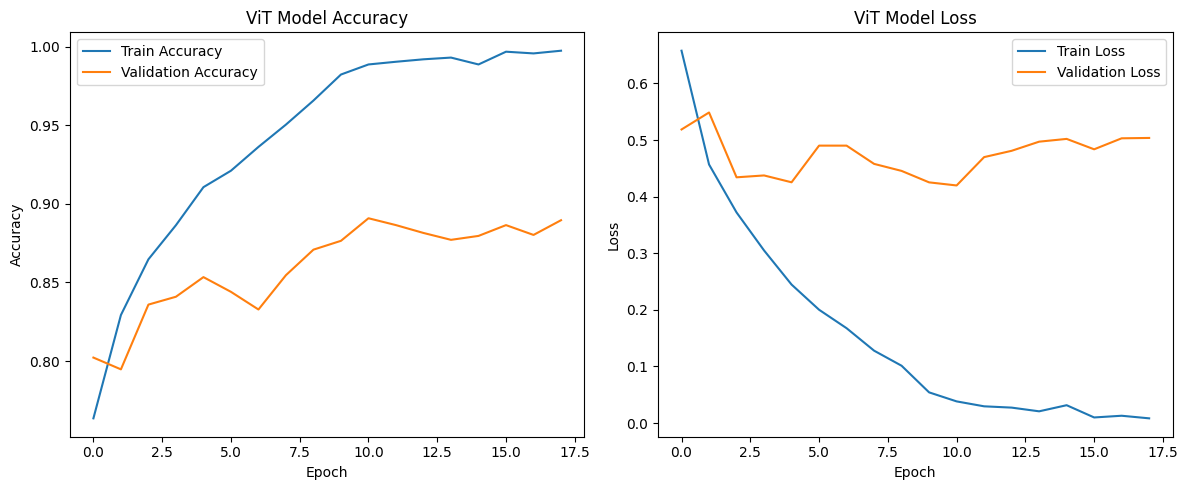

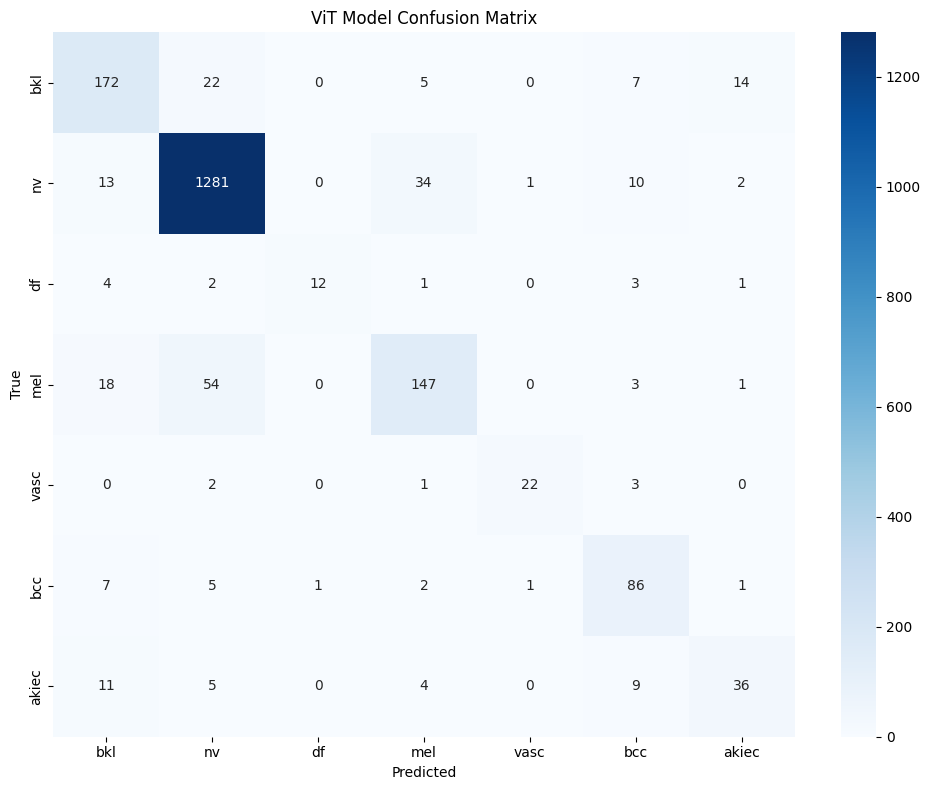

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = "./data"  # Update this to your actual data directory
METADATA_FILE = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
IMAGES_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
OUTPUT_DIR = "./output_vit"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224  # ViT standard input size
BATCH_SIZE = 16  # Reduced batch size for stability
EPOCHS = 100    # Reduced epochs to test functionality
LEARNING_RATE = 0.0001

# Load and prepare metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_FILE)
CLASS_NAMES = df["dx"].unique()
class_to_index = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
df["label"] = df["dx"].map(class_to_index)
print(f"Found {len(df)} images with {len(CLASS_NAMES)} classes: {', '.join(CLASS_NAMES)}")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_path_cache = {}  # Cache for found image paths

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_id = self.dataframe.iloc[idx]["image_id"]
            label = self.dataframe.iloc[idx]["label"]

            # Add .jpg extension if needed
            if not image_id.endswith('.jpg'):
                image_id = f"{image_id}.jpg"

            # Check cache first
            if image_id in self.image_path_cache:
                image_path = self.image_path_cache[image_id]
            else:
                # Try to find the image in both directories
                image_path = None
                for directory in [IMAGES_DIR_1, IMAGES_DIR_2]:
                    potential_path = os.path.join(directory, image_id)
                    if os.path.exists(potential_path):
                        image_path = potential_path
                        self.image_path_cache[image_id] = image_path  # Cache the found path
                        break

            if image_path is None:
                # Return a black image as placeholder
                image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            else:
                image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_id if 'image_id' in locals() else 'unknown'}: {e}")
            # Return a black image and the label as fallback
            image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            return image, torch.tensor(label if 'label' in locals() else 0, dtype=torch.long)

# Create datasets
print("Creating datasets...")
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_test_transform)

# Create dataloaders - using single-process loading for stability
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Dataloaders created")

# Vision Transformer (ViT) Model
class ViTSkinCancerModel(nn.Module):
    def __init__(self, num_classes=len(CLASS_NAMES)):
        super(ViTSkinCancerModel, self).__init__()

        # Load pretrained ViT model
        self.vit = vit_b_16(pretrained=True)

        # Replace the classification head
        vit_out_features = 768   # ViT-B/16 feature dimension
        self.vit.heads = nn.Linear(vit_out_features, num_classes)

        # Freeze early layers to avoid overfitting
        # Freeze all layers except the last transformer block and head
        for name, param in list(self.vit.named_parameters())[:-50]:
            param.requires_grad = False

    def forward(self, x):
        return self.vit(x)

# Function to print model summary
def print_model_summary(model):
    """Print model summary - parameters and structure."""
    print("\nModel Summary:")
    print("=" * 50)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model structure
    print("\nModel Structure:")
    print(model)
    print("=" * 50)

# Create model
print("Creating ViT model...")
model = ViTSkinCancerModel().to(device)

# Print model summary
print_model_summary(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping parameters
    patience = 7  # Number of epochs to wait for improvement
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")

        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]")

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                val_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_val_loss = running_loss / len(val_dataset)
        epoch_val_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)

        # Save the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_vit_model.pth'))
            print(f"New best model saved with accuracy: {best_val_acc:.4f}")

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0  # Reset counter if validation loss improves
        else:
            counter += 1  # Increment counter if no improvement
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break  # Stop training

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(OUTPUT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': epoch_val_loss,
                'val_acc': epoch_val_acc,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

        print()

    return model, history

# Train the model
try:
    print("Starting ViT model training...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=EPOCHS,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('ViT Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('ViT Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'vit_training_history.png'))
    print("Training history plotted and saved")

except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc, all_preds, all_labels

# Load best model and evaluate
try:
    print("Loading best ViT model for evaluation...")
    best_model_path = os.path.join(OUTPUT_DIR, 'best_vit_model.pth')

    # Check if the model file exists
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print("Best model loaded successfully")
    else:
        print("No saved model found, using the last trained model")

    test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion, device)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('ViT Model Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'vit_confusion_matrix.png'))

    # Classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Save classification report to file
    with open(os.path.join(OUTPUT_DIR, 'vit_classification_report.txt'), 'w') as f:
        f.write(report)

    print("ViT model evaluation complete!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()